In [1]:
import requests
from web3 import Web3
from bs4 import BeautifulSoup
import pandas as pd
import json
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats

In [2]:
protocols = ["gmx", "frax-finance", "convex-finance", "curve-finance", "synthetix", 'dYdX', 'gains-network', 'umami-finance', 'LooksRare', 'Beefy', 'ribbon', 'redacted-protocol', 'dopex', 'kujira-protocol', 'polynomial-protocol','Lido', 'MakerDAO', 'aave', 'JustLend', 'uniswap', 'compound-finance', 'pancakeswap', 'venus', 'pendle', 'morpho','liquity','benqi','aura','stargate','thorchain','radiant','spark','binance-staked-eth','instadapp','mantle-staked-eth']
protocols_pools = ['frax', 'gmx-v1', 'gmx-v2', 'curve-dex', "synthetix", 'dydx', 'looksrare', 'beefy', "convex-finance",'gains-network','umami-finance', 'ribbon','makerdao','lido','aave-v3','pancakeswap-amm','venus-core-pool','justland','uniswap-v2','uniswap-v2','compound-v3','pendle','morpho-aave','liquity','benqi-lending','aura','stargate','thorchain','radiant-v2','spark','binance-staked-eth','instadapp','mantle-staked-eth']
token_symbols = ['dydx', 'cvx', 'crv', 'crvusd', 'gmx', 'bifi', 'looks', 'snx', 'umami', 'frax', 'gns']

In [3]:
protocols_100 = ["Lido",'MakerDAO','aave','JustLend','uniswap','rocket-pool','Summer.fi','Spark','Instadapp','compound-finance','EigenLayer','binance-staked-eth','pancakeswap','stUSDT','Blast','JustStables', 'marinade-finance','venus','blancer','mantle-staked-eth','jito','pendle','morpho','stakestone','ether.fi','liquity','benqi','aura','swell','defisaver','coinbase-wrapped-staked-eth','sun','magpie-ecosystem','marginfi','prisma-finance','stader','sushi','tornado-cash','layerbank','stargate','yearn','kamino','uncx-network','kelpdao','thorchain','puffer-finance','pulsex','blazestake','lybra-finance','radiant','stakewise','wemix.fi','coinwind','lightning-network','pinksale','nexus-mutual','silo-finance','osmosis-dex','ondo-finance','hatom-protocol','renzo','katana-dex','arrakis-finance','solend','vvs-finance','orca','mountain-protocol','trader-joe','raydium','hyperliquid','aerodrome','velodrome','blur','glif','liquidloans','enzyme-finance','drift','team-finance','tectonic','abracadabra','kinza-finance','camelot','kujira-protocol','quickswap','Scallop',
'RealT','navi-protocol','folks-finance','origin-defi','loopring','chainge-finance','stride','thala']

# TVL

In [4]:
def fetch_tvl_data(protocol):
    url = f"https://api.llama.fi/protocol/{protocol}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"An error occurred: {err}")

def parse_data(data, field='tvl', subfield=None):
    if field in data and isinstance(data[field], list):
        data_df = pd.DataFrame(data[field])
        if 'date' in data_df.columns:
            data_df['date'] = pd.to_datetime(data_df['date'], unit='s')
        if subfield:
            data_df = data_df[['date', subfield]]
        return data_df
    return pd.DataFrame()

In [5]:
# Extract TVL
tvl_dfs = {}
for protocol in protocols:
    data = fetch_tvl_data(protocol)
    if data:
        tvl_df = parse_data(data, 'tvl')
        tvl_dfs[f"{protocol}_tvl"] = tvl_df
        print(f"{protocol} TVL Data:")
        print(tvl_df.head())
        print("\n")

gmx TVL Data:
        date  totalLiquidityUSD
0 2021-09-01       9.834585e+03
1 2021-09-02       1.265840e+06
2 2021-09-03       2.107099e+06
3 2021-09-04       2.224542e+06
4 2021-09-05       2.243536e+06


frax-finance TVL Data:
        date  totalLiquidityUSD
0 2020-12-17       1.490785e+02
1 2020-12-18       2.177856e+02
2 2020-12-19       2.112384e+02
3 2020-12-20       2.105381e+02
4 2020-12-21       2.248087e+06


convex-finance TVL Data:
                 date  totalLiquidityUSD
0 2021-05-17 00:00:00       6.887735e+07
1 2021-05-18 22:00:00       2.050221e+08
2 2021-05-19 22:00:00       1.905626e+08
3 2021-05-20 22:00:00       2.030479e+08
4 2021-05-21 22:00:00       2.713970e+08


curve-finance TVL Data:
        date  totalLiquidityUSD
0 2020-02-09       1.163733e+06
1 2020-02-10       1.372110e+06
2 2020-02-11       8.936019e+03
3 2020-02-12       3.813938e+04
4 2020-02-13       2.733316e+05


synthetix TVL Data:
                 date  totalLiquidityUSD
0 2019-08-09 22:00:00  

# Fee

In [6]:
base_url = "https://api.llama.fi/summary/fees"
fee_dfs = {}

for protocol in protocols:
    url = f"{base_url}/{protocol}?dataType=dailyFees"
    response = requests.get(url)
    
    if response.status_code == 200:
        
        data = response.json()
        
        if 'totalDataChart' in data and data['totalDataChart'] != None:
            total_data_chart = data['totalDataChart']
            df = pd.DataFrame(total_data_chart)
            
            df.columns = ['time', 'totalDataChart']

            df['time'] = pd.to_datetime(df['time'], unit='s')
            
            df.rename(columns={'time': 'date'}, inplace=True)
            
            df.rename(columns={'totalDataChart': 'Fee'}, inplace=True)

            fee_dfs[protocol] = df
        else:
            print(f"'totalDataChart' not found in data for {protocol}")
    else:
        print(f"Failed to fetch data for {protocol}. Status code: {response.status_code}")

for protocol, df in fee_dfs.items():
    print(f"Data for {protocol}:\n", df.head())

Failed to fetch data for umami-finance. Status code: 404
Failed to fetch data for Beefy. Status code: 404
Failed to fetch data for ribbon. Status code: 404
Failed to fetch data for redacted-protocol. Status code: 404
Failed to fetch data for kujira-protocol. Status code: 502
Failed to fetch data for polynomial-protocol. Status code: 502
'totalDataChart' not found in data for pancakeswap
Failed to fetch data for spark. Status code: 404
Failed to fetch data for binance-staked-eth. Status code: 404
Failed to fetch data for mantle-staked-eth. Status code: 404
Data for gmx:
         date          Fee
0 2021-09-02  3340.504373
1 2021-09-03  4537.888617
2 2021-09-04  1070.665313
3 2021-09-05  1167.313005
4 2021-09-06  6340.075903
Data for frax-finance:
         date     Fee
0 2021-12-23    0.32
1 2021-12-24   20.23
2 2021-12-25   68.91
3 2021-12-26    0.08
4 2021-12-27  205.02
Data for convex-finance:
         date           Fee
0 2021-05-18  14311.481326
1 2021-05-19      0.000000
2 2021-05-

# Yield

In [7]:
base_url = "https://yields.llama.fi"

pools_endpoint = "/pools"

response = requests.get(base_url + pools_endpoint)

if response.status_code == 200:
    
    pools_data = response.json()

    pools = pools_data.get('data', [])

    pool_ids = {}

    for pool in pools:
        name = pool.get("project")
        pool_id = pool.get("pool")

        if name in protocols_pools:
            if name in protocols_pools:
                pool_ids[name] = pool_id
    print("Pool IDs for the specified protocols:")
    for protocol, pool_id in pool_ids.items():
        print(f"{protocol}: {pool_id}")

else:
    print(f"Failed to fetch pool data. Status code: {response.status_code}")


Pool IDs for the specified protocols:
lido: bf3a7f07-80a0-4d5b-a311-b0f06f650f83
aave-v3: ed65f084-3713-492f-8f17-bfda467968c4
binance-staked-eth: 566c64cb-c1ec-4027-bb67-1e9326d6d48a
spark: bcbf3b54-3def-4257-97a8-065a7241e7cb
mantle-staked-eth: b9f2f00a-ba96-4589-a171-dde979a23d87
makerdao: 404b111e-1619-47a9-a99b-431ebe53d0af
liquity: ddd25534-e3d5-4e4e-9b99-d3102323ac61
venus-core-pool: f02223ca-a69e-47df-8795-6657a8f829ee
compound-v3: 68e30785-53bf-49ef-892f-88b197c6bfe6
pendle: 5ed707a5-c562-4e45-aaa7-399cbe2869cc
morpho-aave: bdc0b857-a1df-4714-82af-420093bc4b3f
curve-dex: d51d5cf5-d1f3-4095-a3d5-f538fd0469f5
gmx-v1: c610c72f-40b7-40e8-8e20-fdd185d56ed8
benqi-lending: f14599e7-ac5d-43ec-a999-f452a30b83ce
uniswap-v2: 93d0bdcb-c52f-4fdc-aee7-c05bc560d3d9
convex-finance: 07d65c41-ee7b-473f-965d-03684c903601
thorchain: a731e404-efea-40a5-a156-7dc59a0903ec
gmx-v2: 0df3d94b-686a-4ec3-8161-43d82f283b5b
frax: 8cd2b4e9-1cf3-40d8-9981-454c33e7cf92
aura: 4120765c-e9fa-4404-9c2a-ae206a0c35e

In [8]:
base_url = "https://yields.llama.fi/chart"

protocol_dfs = {}

for protocol, pool_id in pool_ids.items():

    url = f"{base_url}/{pool_id}"

    response = requests.get(url)

    if response.status_code == 200:

        data = response.json()
        df = pd.DataFrame(data)

        protocol_dfs[protocol] = df

        print(f"Yield data for {protocol} has been successfully retrieved and stored in a DataFrame.")
        
    else:
        print(f"Failed to fetch yield data for {protocol}. Status code: {response.status_code}")

Yield data for lido has been successfully retrieved and stored in a DataFrame.
Yield data for aave-v3 has been successfully retrieved and stored in a DataFrame.
Yield data for binance-staked-eth has been successfully retrieved and stored in a DataFrame.
Yield data for spark has been successfully retrieved and stored in a DataFrame.
Yield data for mantle-staked-eth has been successfully retrieved and stored in a DataFrame.
Yield data for makerdao has been successfully retrieved and stored in a DataFrame.
Yield data for liquity has been successfully retrieved and stored in a DataFrame.
Yield data for venus-core-pool has been successfully retrieved and stored in a DataFrame.
Yield data for compound-v3 has been successfully retrieved and stored in a DataFrame.
Yield data for pendle has been successfully retrieved and stored in a DataFrame.
Yield data for morpho-aave has been successfully retrieved and stored in a DataFrame.
Yield data for curve-dex has been successfully retrieved and store

In [9]:
yield_dfs = {}

for protocol, df in protocol_dfs.items():
    
    df['timestamp'] = df['data'].apply(lambda x: datetime.strptime(x['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ"))
    
    df['APY'] = df['data'].apply(lambda x: x['apy'])

    df_cleaned = df.drop(columns=['data', 'status'])

    yield_dfs[protocol] = df_cleaned

    print(f"Data for {protocol} cleaned and stored.")

Data for lido cleaned and stored.
Data for aave-v3 cleaned and stored.
Data for binance-staked-eth cleaned and stored.
Data for spark cleaned and stored.
Data for mantle-staked-eth cleaned and stored.
Data for makerdao cleaned and stored.
Data for liquity cleaned and stored.
Data for venus-core-pool cleaned and stored.
Data for compound-v3 cleaned and stored.
Data for pendle cleaned and stored.
Data for morpho-aave cleaned and stored.
Data for curve-dex cleaned and stored.
Data for gmx-v1 cleaned and stored.
Data for benqi-lending cleaned and stored.
Data for uniswap-v2 cleaned and stored.
Data for convex-finance cleaned and stored.
Data for thorchain cleaned and stored.
Data for gmx-v2 cleaned and stored.
Data for frax cleaned and stored.
Data for aura cleaned and stored.
Data for instadapp cleaned and stored.
Data for radiant-v2 cleaned and stored.
Data for pancakeswap-amm cleaned and stored.
Data for gains-network cleaned and stored.
Data for stargate cleaned and stored.


In [10]:
for protocol, df in yield_dfs.items():

    df['timestamp'] = df['timestamp'].dt.date
    
    df.rename(columns={'timestamp': 'date'}, inplace=True)

    yield_dfs[protocol] = df

    print(f"Data for {protocol} updated.")

Data for lido updated.
Data for aave-v3 updated.
Data for binance-staked-eth updated.
Data for spark updated.
Data for mantle-staked-eth updated.
Data for makerdao updated.
Data for liquity updated.
Data for venus-core-pool updated.
Data for compound-v3 updated.
Data for pendle updated.
Data for morpho-aave updated.
Data for curve-dex updated.
Data for gmx-v1 updated.
Data for benqi-lending updated.
Data for uniswap-v2 updated.
Data for convex-finance updated.
Data for thorchain updated.
Data for gmx-v2 updated.
Data for frax updated.
Data for aura updated.
Data for instadapp updated.
Data for radiant-v2 updated.
Data for pancakeswap-amm updated.
Data for gains-network updated.
Data for stargate updated.


# Defining functions to be used

In [21]:
# Function used to extracting data from dune
def dune_get(metric, date_col, data_col, url):
    
    if metric == 'user':
        col_name = 'User Growth'
    if metric == 'supply':
        col_name = 'Supply'
    if metric == 'staking':
        col_name = 'Staking'
    if metric == 'addr':
        col_name = 'Unique Addresses'
    if metric == 'apy':
        col_name = 'APY'
    if metric == 'tvl':
        col_name = 'TVL'
    if metric == 'fee':
        col_name = 'Fee'
    if metric == 'trade volume':
        col_name = 'Trade Volume'

    
    key = 'api_key=WCDUex9Dd2BA7Aa8S6cwYbtQzwDa7VB5'
    base_url = url + key
    
    page = requests.get(base_url)
    response = json.loads(page.text)
  
    df = pd.DataFrame(response['result']['rows'])
    
    df = df[[date_col, data_col]]
    df[date_col] = pd.to_datetime(df[date_col]).dt.date
    df.rename(columns = {date_col: 'date', data_col: col_name}, inplace = True)
    df = df.sort_values(by='date').reset_index(drop=True)
    return df

In [12]:
# Put data extracted for a certain protocol in a certain dict 
protocol_dict = {
    'tvl': None,  
    'fee':None,
    'apy': None,
    'supply': None,
    'staking':None,
    'address':None,
    'userg':None,
    'trades':None
}
def get_dict(protocol, standard_dict):
    
    protocol_dict = {}
    
    global_namespace = globals()
    for key in standard_dict.keys():

        df_name = f'df_{protocol}_{key}'

        if df_name in global_namespace:
            
            protocol_dict[key] = global_namespace[df_name]
            
        else:
            
            print(f"DataFrame named {df_name} not found.")
            
    return protocol_dict

In [13]:
# Using the dict we have for each protocol to generate a df
def combine(data_dict, col='date', method='outer'):
    
    combined_df = None

    for key, df in data_dict.items():
        
        if df is None:
            continue
        
        if combined_df is None:
            combined_df = df
            
        else:
            combined_df = pd.merge(combined_df, df, on=col, how=method)

    return combined_df

In [14]:
# a anxiliary function to insure the datetime nature of every seperate df by inputting the protocol dict
def convert_date_columns(data_dict):

    for key, df in data_dict.items():
        
        if 'date' in df.columns:
            
            df['date'] = pd.to_datetime(df['date']).dt.date
            
        else:
            print(f"'date' column not found in DataFrame associated with key '{key}'")
    
    return data_dict

In [15]:
# Checking and getting ready for time series manipulation
def pre_checking(df):
    
    # Check data frame shape 
    print("DataFrame Shape:", df.shape)
    # Print overview of data frame 
    print("DataFrame Overview:")
    print(df.info())

def add_ts_columns(df):
    
    # Time series data manipulation:
    # New column: day of week, week of the month, number of the month, hour of the day 
    df['DayOfWeek'] = pd.to_datetime(df['date']).dt.dayofweek
    df['WeekOfMonth'] = pd.to_datetime(df['date']).apply(lambda d: (d.day-1)//7 + 1)
    df['MonthNumber'] = pd.to_datetime(df['date']).dt.month
    df['HourOfDay'] = pd.to_datetime(df['date']).dt.hour

def checking_nas(df):
    
    # Missing values:
    # Check for missing values which has more than 10% 
    missing_values_over_10 = df.isnull().mean() > 0.1
    print("Missing values over 10%:", missing_values_over_10)
    
    # Check for missing values which has less than 10% 
    missing_values_under_10 = df.isnull().mean() < 0.1
    print("Missing values under 10%:", missing_values_under_10)

    # Drop all columns with 60% or more missing values 
    df.dropna(thresh=len(df) * 0.4, axis=1, inplace=True)

    # Check for missing values which has more than 0% 
    missing_values_over_0 = df.isnull().mean() > 0
    print("Missing values over 0%:", missing_values_over_0)

In [16]:
# Cleaning

def handle_nas(df):

    for column in df.columns:
        
        if df[column].dtype == 'float64' or df[column].dtype == 'int64':
            if pd.isna(df[column].iloc[0]):
                df[column].iloc[0] = '0'
            
            df[column].fillna(df[column].ffill(), inplace=True)


    return df

def handle_outliers_mask(df):
    
    # Outliers:
    # Identify outliers in the dataset
    lof = LocalOutlierFactor()
    outliers = lof.fit_predict(df.select_dtypes(include=[np.number])) == -1
    
    # Create a mask for rows that are not outliers
    mask = ~outliers

    # Apply the mask to the original DataFrame
    df_no_outliers = df[mask]

    # Print the shape of the original DataFrame and the DataFrame after removing outliers
    print("Original DataFrame shape:", df.shape)
    print("DataFrame after removing outliers shape:", df_no_outliers.shape)
    
    return df_no_outliers

def handle_outliers(df, method='z-score'):

    df_cleaned = df.copy()

    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        
        if method == 'z-score':
            
            # Calculate Z-scores for the column
            z_scores = np.abs(stats.zscore(df_cleaned[column]))
            
            # Remove rows with Z-scores greater than 3 in the column
            df_cleaned = df_cleaned[(z_scores < 3) | (z_scores.isna())]
            
        elif method == 'iqr':
            
            # Calculate IQR for the column
            Q1 = df_cleaned[column].quantile(0.25)
            Q3 = df_cleaned[column].quantile(0.75)
            IQR = Q3 - Q1
            
            # Filter out outliers in the column
            df_cleaned = df_cleaned[~((df_cleaned[column] < (Q1 - 1.5 * IQR)) | (df_cleaned[column] > (Q3 + 1.5 * IQR))) | (df_cleaned[column].isna())]

    return df_cleaned

def handle_duplicates(df):

    duplicates = df.duplicated()
    print('Duplicates: ', duplicates)

    df_no_duplicates = df.drop_duplicates()

    return df_no_duplicates

def plot_column_boxplots(df):
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    df[numeric_cols].plot(kind='box', subplots=True, layout=(len(numeric_cols)//3 + 1, 3), figsize=(15, len(numeric_cols)*2))
    
    plt.tight_layout()
    
    plt.show()

In [17]:
# Visualizing the collinearity
def collinearity(df):

    df_no_date = df.drop(columns=['date'], errors='ignore')

    corr_matrix = df_no_date.corr()
    
    sns.heatmap(corr_matrix, annot=True)
    plt.show()

    return corr_matrix

In [18]:
# Drop features that are not useful for ‘Rank Select’ (drop unnecessary columns)

# Standardize categorical variables if any 

# ENCODING 

# binary encoding

# numerical category encoding

In [19]:
# only get data starting from 2023.01.01
cutoff_date = datetime(2022, 12, 31).date()

# DYDX (Yield, Fee, Unique Address too few observations, User Growth Missing)

In [355]:
# Supply
df_dydx_supply = dune_get('supply', 'day', 'Total Claimed DYDX by Day', 'https://api.dune.com/api/v1/query/414490/results?')

In [356]:
# Unique Addresses
df_dydx_address = dune_get('addr', 'day', 'unique_user', 'https://api.dune.com/api/v1/query/2845333/results?')

In [357]:
# Liquidity (Staking Pool)
df_dydx_stakig = dune_get('staking', 'day', 'cumulative_staked', 'https://api.dune.com/api/v1/query/935766/results?')

In [358]:
# Daily Trade volume
df_dydx_trades = dune_get('trade volume', 'day', 'trade_volume', 'https://api.dune.com/api/v1/query/3397179/results?')

In [359]:
# TVL
df_dydx_tvl = tvl_dfs.get('dYdX_tvl')
df_dydx_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_dydx_tvl['date'] = pd.to_datetime(df_dydx_tvl['date']).dt.date

In [360]:
# Summerizing all to one dict for convenience
dict_dydx = get_dict('dydx', protocol_dict)

DataFrame named df_dydx_fee not found.
DataFrame named df_dydx_apy not found.
DataFrame named df_dydx_staking not found.
DataFrame named df_dydx_userg not found.


In [361]:
# Combining
df_dydx = combine(dict_dydx)
df_dydx = df_dydx[df_dydx['date'] > cutoff_date]
df_dydx

,date,TVL,Supply,Unique Addresses,Trade Volume
783,2023-01-01,3.943898e+08,2.451076e+04,NaN,95910.720337
784,2023-01-02,3.923215e+08,7.156884e+04,NaN,78344.385518
785,2023-01-03,3.955949e+08,5.167584e+04,NaN,125262.304084
786,2023-01-04,3.976181e+08,1.496895e+06,NaN,104873.137589
787,2023-01-05,3.965796e+08,3.228726e+04,NaN,151241.850225
...,...,...,...,...,...
1224,2024-03-17,4.058563e+08,NaN,NaN,NaN
1225,2024-03-18,4.039711e+08,NaN,NaN,NaN
1226,2024-03-19,4.029669e+08,NaN,NaN,NaN
1227,2024-03-20,3.939918e+08,NaN,NaN,NaN


In [362]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_dydx)
add_ts_columns(df_dydx)
checking_nas(df_dydx)

DataFrame Shape: (446, 5)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 783 to 1228
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              446 non-null    object 
 1   TVL               446 non-null    float64
 2   Supply            114 non-null    float64
 3   Unique Addresses  373 non-null    float64
 4   Trade Volume      398 non-null    float64
dtypes: float64(4), object(1)
memory usage: 20.9+ KB
None
Missing values over 10%: date                False
TVL                 False
Supply               True
Unique Addresses     True
Trade Volume         True
DayOfWeek           False
WeekOfMonth         False
MonthNumber         False
HourOfDay           False
dtype: bool
Missing values under 10%: date                 True
TVL                  True
Supply              False
Unique Addresses    False
Trade Volume        False
DayOfWeek            True
WeekOfMonth 

In [363]:
# Cleaning process, na and duplicates part
df_dydx_cleaned = handle_nas(df_dydx)
df_dydx_cleaned = handle_duplicates(df_dydx_cleaned)

Duplicates:  783     False
784     False
785     False
786     False
787     False
        ...  
1224    False
1225    False
1226    False
1227    False
1228    False
Length: 446, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'


In [364]:
# Final check for any missing values
print("Final check for missing values:")
print(df_dydx_cleaned.isnull().sum())

Final check for missing values:
date                0
TVL                 0
Unique Addresses    0
Trade Volume        0
DayOfWeek           0
WeekOfMonth         0
MonthNumber         0
HourOfDay           0
dtype: int64


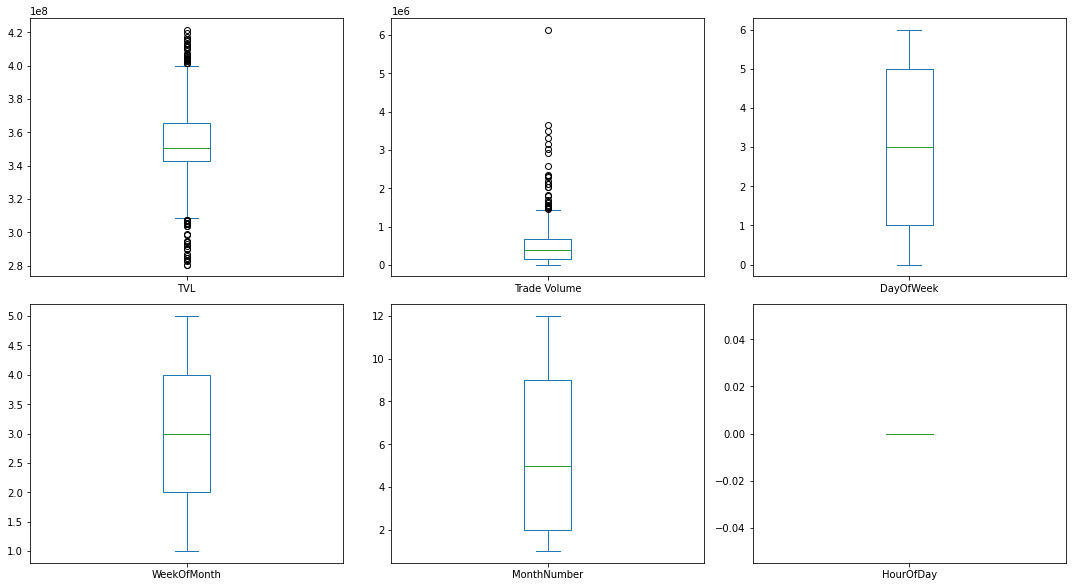

Original DataFrame shape: (446, 8)
DataFrame after removing outliers shape: (414, 8)


In [365]:
# Outliers part
plot_column_boxplots(df_dydx_cleaned)
df_dydx_cleaned = handle_outliers_mask(df_dydx_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


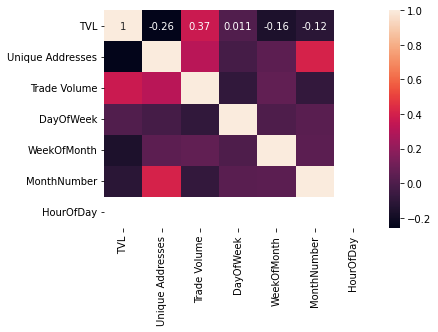

In [366]:
# Checking collinearity
corr_dydx = collinearity(df_dydx_cleaned)

In [367]:
df_dydx_cleaned

,date,TVL,Unique Addresses,Trade Volume,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
783,2023-01-01,3.943898e+08,0,95910.720337,6,1,1,0
784,2023-01-02,3.923215e+08,0,78344.385518,0,1,1,0
785,2023-01-03,3.955949e+08,0,125262.304084,1,1,1,0
786,2023-01-04,3.976181e+08,0,104873.137589,2,1,1,0
787,2023-01-05,3.965796e+08,0,151241.850225,3,1,1,0
...,...,...,...,...,...,...,...,...
1224,2024-03-17,4.058563e+08,13.0,676222.648103,6,3,3,0
1225,2024-03-18,4.039711e+08,13.0,676222.648103,0,3,3,0
1226,2024-03-19,4.029669e+08,13.0,676222.648103,1,3,3,0
1227,2024-03-20,3.939918e+08,13.0,676222.648103,2,3,3,0


In [368]:
df_dydx_cleaned.to_csv('dydx_cleaned.csv', index=False)

# UMAMI (Fee missing, APY too few observations)

In [369]:
# Supply
df_umami_supply = dune_get('supply', 'date', 'total_UMAMI', 'https://api.dune.com/api/v1/query/1155004/results?')

In [370]:
# Unique Addresses
df_umami_address = dune_get('addr', 'day', 'Total_Unique_Buyers', 'https://api.dune.com/api/v1/query/1027042/results?')

In [371]:
# User Growth
df_umami_userg = dune_get('user', 'block_date', 'accumulate_user_count', 'https://api.dune.com/api/v1/query/1151054/results?')

In [372]:
# Liquidity (Staking Pool)
df_umami_staking = dune_get('staking', 'day', 'staked_umami_daily_overtime', 'https://api.dune.com/api/v1/query/1959414/results?')

In [373]:
# TVL
df_umami_tvl = tvl_dfs.get('umami-finance_tvl')
df_umami_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_umami_tvl['date'] = pd.to_datetime(df_umami_tvl['date']).dt.date

In [374]:
# Yield
df_umami_apy = yield_dfs.get('umami-finance')

In [375]:
# Summerizing all to one dict for convenience
dict_umami = get_dict('umami', protocol_dict)

DataFrame named df_umami_fee not found.
DataFrame named df_umami_trades not found.


In [376]:
# Combining
df_umami = combine(dict_umami)
df_umami = df_umami[df_umami['date'] > cutoff_date]

In [377]:
df_umami

,date,TVL,Supply,Staking,Unique Addresses,User Growth
424,2023-01-01,3.022260e+04,999985.950001,540165.159183,71062.0,214850.0
425,2023-01-02,3.018945e+04,999985.950001,532521.274340,71152.0,216144.0
426,2023-01-03,3.019241e+04,999985.950001,533247.840925,71240.0,217946.0
427,2023-01-04,3.019241e+04,999985.950001,534547.279758,71306.0,219175.0
428,2023-01-05,3.022260e+04,999985.950001,535194.609380,71506.0,220561.0
...,...,...,...,...,...,...
864,2024-03-16,7.919014e+06,NaN,NaN,NaN,NaN
865,2024-03-17,7.579053e+06,NaN,NaN,NaN,NaN
866,2024-03-18,7.657794e+06,NaN,NaN,NaN,NaN
867,2024-03-19,7.289279e+06,NaN,NaN,NaN,NaN


In [378]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_umami)
add_ts_columns(df_umami)
checking_nas(df_umami)

DataFrame Shape: (445, 6)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 424 to 868
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              445 non-null    object 
 1   TVL               445 non-null    float64
 2   Supply            113 non-null    float64
 3   Staking           96 non-null     float64
 4   Unique Addresses  106 non-null    float64
 5   User Growth       114 non-null    float64
dtypes: float64(5), object(1)
memory usage: 24.3+ KB
None
Missing values over 10%: date                False
TVL                 False
Supply               True
Staking              True
Unique Addresses     True
User Growth          True
DayOfWeek           False
WeekOfMonth         False
MonthNumber         False
HourOfDay           False
dtype: bool
Missing values under 10%: date                 True
TVL                  True
Supply              False
Staking           

In [379]:
# Cleaning process, na and duplicates part
df_umami_cleaned = handle_nas(df_umami)
df_umami_cleaned = handle_duplicates(df_umami_cleaned)

Duplicates:  424    False
425    False
426    False
427    False
428    False
       ...  
864    False
865    False
866    False
867    False
868    False
Length: 445, dtype: bool


In [380]:
# Final check for any missing values
print("Final check for missing values:")
print(df_umami_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


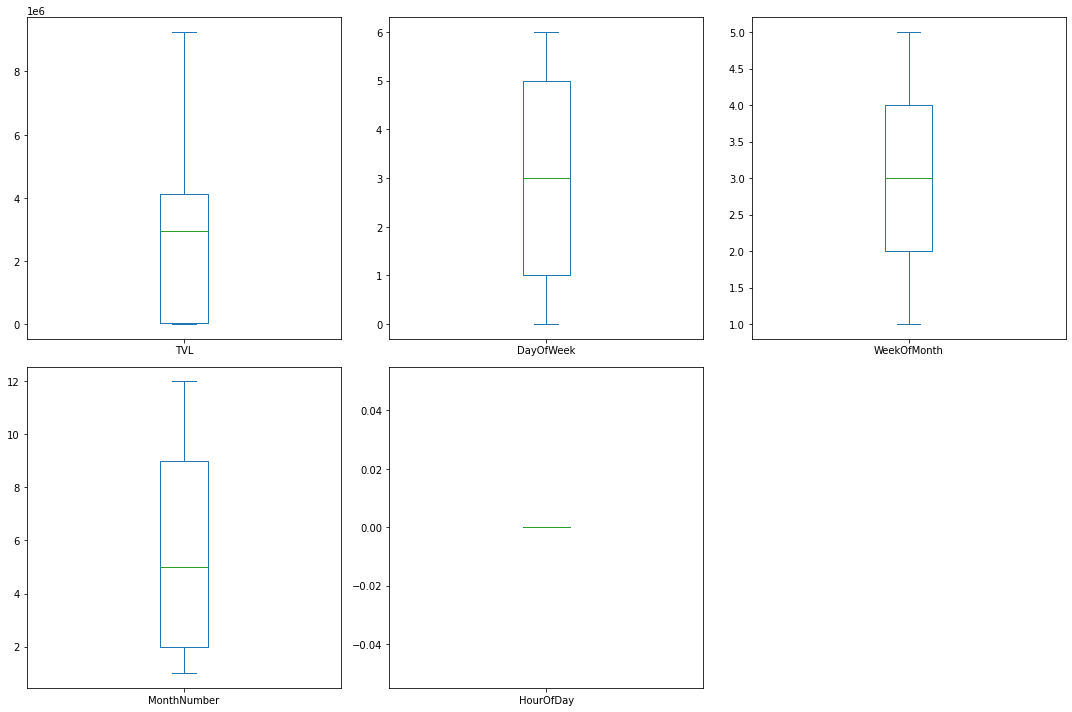

Original DataFrame shape: (445, 6)
DataFrame after removing outliers shape: (374, 6)


In [381]:
# Outliers part
plot_column_boxplots(df_umami_cleaned)
df_umami_cleaned = handle_outliers_mask(df_umami_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


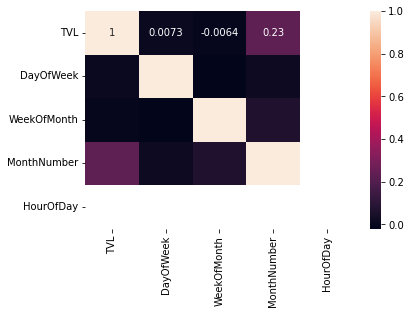

In [382]:
# Checking collinearity
corr_umami = collinearity(df_umami_cleaned)

In [383]:
df_umami_cleaned

,date,TVL,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
424,2023-01-01,3.022260e+04,6,1,1,0
425,2023-01-02,3.018945e+04,0,1,1,0
426,2023-01-03,3.019241e+04,1,1,1,0
427,2023-01-04,3.019241e+04,2,1,1,0
428,2023-01-05,3.022260e+04,3,1,1,0
...,...,...,...,...,...,...
863,2024-03-15,8.735710e+06,4,3,3,0
864,2024-03-16,7.919014e+06,5,3,3,0
865,2024-03-17,7.579053e+06,6,3,3,0
866,2024-03-18,7.657794e+06,0,3,3,0


# GNS ( Unique Addresses too few observations)

In [384]:
# Supply
df_gns_supply = dune_get('supply', 'day', 'overall_supply', 'https://api.dune.com/api/v1/query/2364116/results?')

In [385]:
# Unique Addresses
df_gns_address = dune_get('addr', 'day', 'unique_traders', 'https://api.dune.com/api/v1/query/3114169/results?')

In [386]:
# User Growth
df_gns_userg = dune_get('user', 'day', 'cumulative_users', 'https://api.dune.com/api/v1/query/2363359/results?')

In [387]:
# Liquidity (Staking Pool)
df_gns_staking = dune_get('staking', 'day', 'staked_gns_overall', 'https://api.dune.com/api/v1/query/2364116/results?')

In [388]:
# Daily Trade volume
df_gns_trades = dune_get('trade volume', 'day', 'trade_volume', 'https://api.dune.com/api/v1/query/3397268/results?')

In [389]:
# TVL
df_gns_tvl = tvl_dfs.get('gains-network_tvl')
df_gns_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_gns_tvl['date'] = pd.to_datetime(df_gns_tvl['date']).dt.date

In [390]:
# Fee
df_gns_fee = fee_dfs.get('gains-network')

In [391]:
# Yield
df_gns_apy = yield_dfs.get('gains-network')

In [392]:
# Summerizing all to one dict for convenience
dict_gns = get_dict('gns', protocol_dict)
dict_gns = convert_date_columns(dict_gns)

In [393]:
# Combining
df_gns = combine(dict_gns)
df_gns = df_gns[df_gns['date'] > cutoff_date]

In [394]:
df_gns

,date,TVL,Fee,APY,Supply,Staking,Unique Addresses,User Growth,Trade Volume
384,2023-01-01,1.920498e+07,7413.685038,NaN,3.035970e+07,2.234809e+07,NaN,9164.0,945246.554982
385,2023-01-02,1.865087e+07,15842.205546,NaN,3.036243e+07,2.260966e+07,NaN,9184.0,192805.931309
386,2023-01-03,1.846876e+07,23020.939293,NaN,3.036359e+07,2.268311e+07,NaN,9219.0,351673.821555
387,2023-01-04,1.863861e+07,32407.345762,NaN,3.036471e+07,2.229919e+07,NaN,9263.0,235782.913822
388,2023-01-05,1.847878e+07,19372.784359,NaN,3.036835e+07,2.296860e+07,NaN,9297.0,528340.438149
...,...,...,...,...,...,...,...,...,...
824,2024-03-16,4.012298e+07,236950.000000,34.84022,3.408976e+07,2.684775e+07,NaN,24473.0,NaN
825,2024-03-17,4.013110e+07,463146.000000,34.93115,3.409006e+07,2.679425e+07,NaN,24503.0,NaN
826,2024-03-18,3.962024e+07,227107.000000,36.65018,3.409063e+07,2.678361e+07,NaN,24535.0,NaN
827,2024-03-19,3.932893e+07,306706.000000,37.45060,3.409287e+07,2.681533e+07,NaN,24568.0,NaN


In [395]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_gns)
add_ts_columns(df_gns)
checking_nas(df_gns)

DataFrame Shape: (445, 9)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 384 to 828
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              445 non-null    object 
 1   TVL               445 non-null    float64
 2   Fee               444 non-null    float64
 3   APY               397 non-null    float64
 4   Supply            445 non-null    float64
 5   Staking           445 non-null    float64
 6   Unique Addresses  120 non-null    float64
 7   User Growth       444 non-null    float64
 8   Trade Volume      397 non-null    float64
dtypes: float64(8), object(1)
memory usage: 34.8+ KB
None
Missing values over 10%: date                False
TVL                 False
Fee                 False
APY                  True
Supply              False
Staking             False
Unique Addresses     True
User Growth         False
Trade Volume         True
DayOfWeek          

In [396]:
# Cleaning process, na and duplicates part
df_gns_cleaned = handle_nas(df_gns)
df_gns_cleaned = handle_duplicates(df_gns_cleaned)

Duplicates:  384    False
385    False
386    False
387    False
388    False
       ...  
824    False
825    False
826    False
827    False
828    False
Length: 445, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'


In [397]:
# Final check for any missing values
print("Final check for missing values:")
print(df_gns_cleaned.isnull().sum())

Final check for missing values:
date            0
TVL             0
Fee             0
APY             0
Supply          0
Staking         0
User Growth     0
Trade Volume    0
DayOfWeek       0
WeekOfMonth     0
MonthNumber     0
HourOfDay       0
dtype: int64


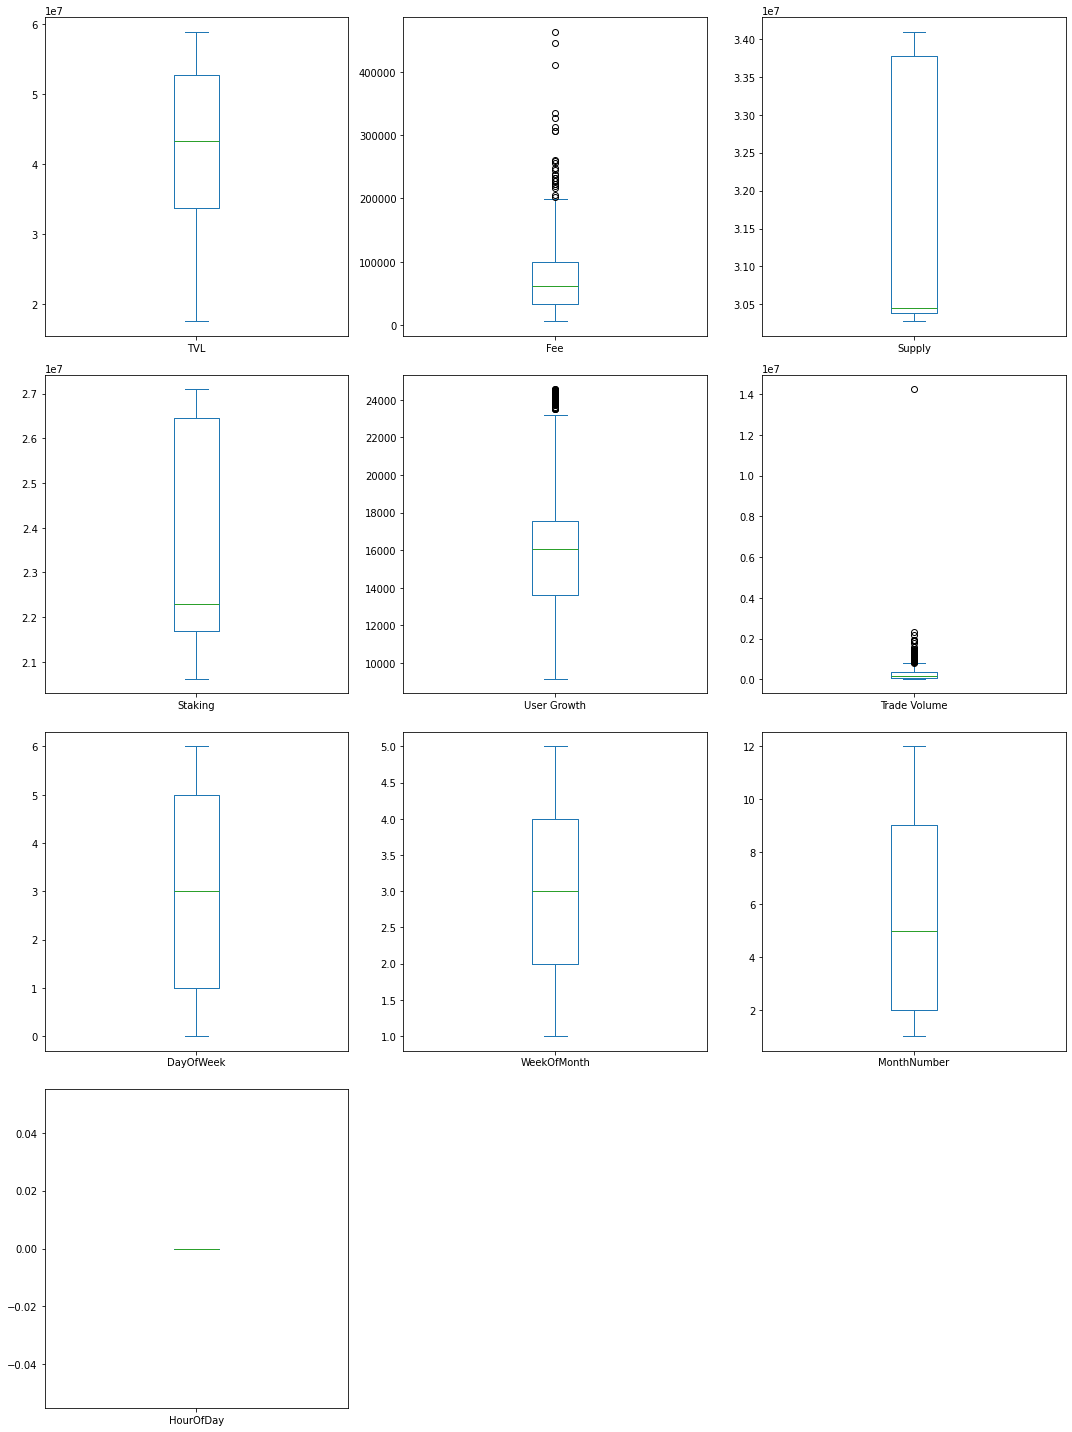

Original DataFrame shape: (445, 12)
DataFrame after removing outliers shape: (418, 12)


In [398]:
# Outliers part
plot_column_boxplots(df_gns_cleaned)
df_gns_cleaned = handle_outliers_mask(df_gns_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


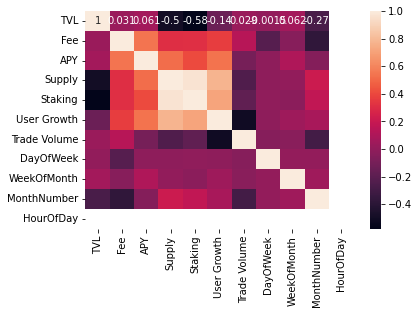

In [399]:
# Checking collinearity
corr_gns = collinearity(df_gns_cleaned)

In [400]:
df_gns_cleaned

,date,TVL,Fee,APY,Supply,Staking,User Growth,Trade Volume,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
384,2023-01-01,1.920498e+07,7413.685038,0,3.035970e+07,2.234809e+07,9164.0,945246.554982,6,1,1,0
385,2023-01-02,1.865087e+07,15842.205546,0,3.036243e+07,2.260966e+07,9184.0,192805.931309,0,1,1,0
386,2023-01-03,1.846876e+07,23020.939293,0,3.036359e+07,2.268311e+07,9219.0,351673.821555,1,1,1,0
387,2023-01-04,1.863861e+07,32407.345762,0,3.036471e+07,2.229919e+07,9263.0,235782.913822,2,1,1,0
388,2023-01-05,1.847878e+07,19372.784359,0,3.036835e+07,2.296860e+07,9297.0,528340.438149,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
824,2024-03-16,4.012298e+07,236950.000000,34.84022,3.408976e+07,2.684775e+07,24473.0,36970.925319,5,3,3,0
825,2024-03-17,4.013110e+07,463146.000000,34.93115,3.409006e+07,2.679425e+07,24503.0,36970.925319,6,3,3,0
826,2024-03-18,3.962024e+07,227107.000000,36.65018,3.409063e+07,2.678361e+07,24535.0,36970.925319,0,3,3,0
827,2024-03-19,3.932893e+07,306706.000000,37.4506,3.409287e+07,2.681533e+07,24568.0,36970.925319,1,3,3,0


# BIFI ( TVL, Supply, Fee, Unique Addresses, User Growth Missing)

In [401]:
# Using official website for supply
bifi_supply_url = 'https://api.beefy.finance/supply'
page_bifi_supply = requests.get(bifi_supply_url)
response_bifi_supply = json.loads(page_bifi_supply.text)

In [402]:
response_bifi_supply

{'total': 80000, 'circulating': 80000}

In [403]:
# TVL
df_bifi_tvl = tvl_dfs.get('Beefy_tvl')
df_bifi_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_bifi_tvl['date'] = pd.to_datetime(df_gns_tvl['date']).dt.date

In [404]:
# Liquidity (Staking Pool)
#bifi_liquidity_url = 'https://api.dune.com/api/v1/query/1585824/results?api_key=FYgR2TDBbCVdYcoEZj48GRww57piuVtr'
#page_bifi_liquidity = requests.get(bifi_liquidity_url)
#response_bifi_liquidity = json.loads(page_bifi_liquidity.text)
#df_bifi_liquidity = pd.DataFrame(response_bifi_liquidity['result']['rows'])

In [405]:
# Processing
#df_bifi_liquidity = df_bifi_liquidity[['day', 'usdc_amount_cumu']]
#df_bifi_liquidity['day'] = pd.to_datetime(df_bifi_liquidity['day']).dt.date
#df_bifi_liquidity.rename(columns = {'day': 'date', 'usdc_amount_cumu': 'Staking'}, inplace = True)
#df_bifi_liquidity = df_bifi_liquidity.sort_values(by='date').reset_index(drop=True)
#df_bifi_staking = df_bifi_liquidity

In [406]:
# Yield
df_bifi_apy = yield_dfs.get('beefy')

In [407]:
# Summerizing all to one dict for convenience
#dict_bifi = get_dict('bifi', protocol_dict)
#dict_bifi = convert_date_columns(dict_bifi)

In [408]:
# Combining
df_bifi = combine(dict_bifi)
df_bifi = df_bifi[df_bifi['date'] > cutoff_date]

In [409]:
df_bifi

,date,TVL
384,2023-01-01,2.667304e+08
385,2023-01-02,2.555878e+08
386,2023-01-03,2.615387e+08
387,2023-01-04,2.403697e+08
388,2023-01-05,2.475604e+08
...,...,...
824,2024-03-16,1.925349e+08
825,2024-03-17,1.893842e+08
826,2024-03-18,1.779625e+08
827,2024-03-19,1.821865e+08


In [410]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_bifi)
add_ts_columns(df_bifi)
checking_nas(df_bifi)

DataFrame Shape: (445, 2)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 384 to 828
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    445 non-null    object 
 1   TVL     445 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.4+ KB
None
Missing values over 10%: date           False
TVL            False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date           True
TVL            True
DayOfWeek      True
WeekOfMonth    True
MonthNumber    True
HourOfDay      True
dtype: bool
Missing values over 0%: date           False
TVL            False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/236859545.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DayOfWeek'] = pd.to_datetime(df['date']).dt.dayofweek
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/236859545.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WeekOfMonth'] = pd.to_datetime(df['date']).apply(lambda d: (d.day-1)//7 + 1)
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/236859545.py:16: SettingWithCopyWarning: 
A value is

In [411]:
# Cleaning process, na and duplicates part
df_bifi_cleaned = handle_nas(df_bifi)
df_bifi_cleaned = handle_duplicates(df_bifi_cleaned)

Duplicates:  384    False
385    False
386    False
387    False
388    False
       ...  
824    False
825    False
826    False
827    False
828    False
Length: 445, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].fillna(df[column].ffill(), inplace=True)


In [412]:
# Final check for any missing values
print("Final check for missing values:")
print(df_bifi_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


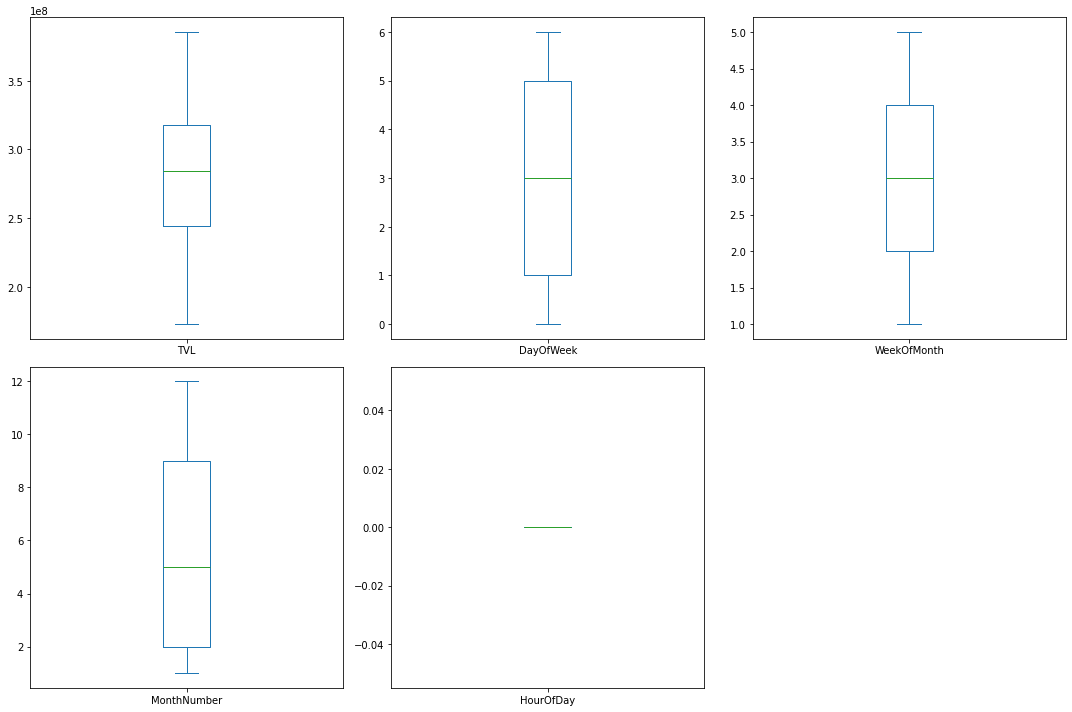

Original DataFrame shape: (445, 6)
DataFrame after removing outliers shape: (435, 6)


In [413]:
# Outliers part
plot_column_boxplots(df_bifi_cleaned)
df_bifi_cleaned = handle_outliers_mask(df_bifi_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


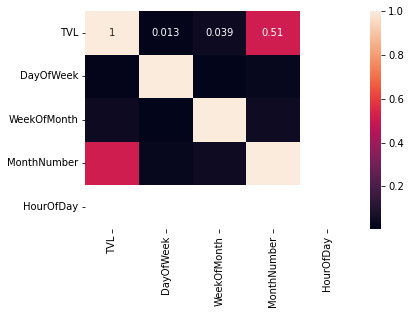

In [414]:
# Checking collinearity
corr_bifi = collinearity(df_bifi_cleaned)

In [415]:
df_bifi_cleaned

,date,TVL,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
384,2023-01-01,2.667304e+08,6,1,1,0
385,2023-01-02,2.555878e+08,0,1,1,0
386,2023-01-03,2.615387e+08,1,1,1,0
387,2023-01-04,2.403697e+08,2,1,1,0
388,2023-01-05,2.475604e+08,3,1,1,0
...,...,...,...,...,...,...
824,2024-03-16,1.925349e+08,5,3,3,0
825,2024-03-17,1.893842e+08,6,3,3,0
826,2024-03-18,1.779625e+08,0,3,3,0
827,2024-03-19,1.821865e+08,1,3,3,0


# Looks (Supply Missing, Staking Missing)

In [416]:
# Unique Addresses
df_looks_address = dune_get('addr', 'day', 'count(DISTINCT address)', 'https://api.dune.com/api/v1/query/1380634/results?')

In [417]:
# User Growth
df_looks_userg = dune_get('user', 'dd', 'uniques', 'https://api.dune.com/api/v1/query/636421/results?')

In [418]:
# TVL
df_looks_tvl = tvl_dfs.get('LooksRare_tvl')
df_looks_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_looks_tvl['date'] = pd.to_datetime(df_looks_tvl['date']).dt.date

In [419]:
# Fee
df_looks_fee = fee_dfs.get('LooksRare')

In [420]:
# Yield
df_looks_apy = yield_dfs.get('looksrare')

In [421]:
# Summerizing all to one dict for convenience
dict_looks = get_dict('looks', protocol_dict)
# dict_looks = convert_date_columns(dict_looks)

DataFrame named df_looks_supply not found.
DataFrame named df_looks_staking not found.
DataFrame named df_looks_trades not found.


In [422]:
# Combining
df_looks = combine(dict_looks)
df_looks = df_looks[df_looks['date'] > cutoff_date]

In [423]:
df_looks

,date,TVL,Fee,Unique Addresses,User Growth
355,2023-01-01,0.0,56849.948829,436.0,138531.0
356,2023-01-02,0.0,65855.946146,511.0,138641.0
357,2023-01-03,0.0,60932.481125,512.0,138773.0
358,2023-01-04,0.0,39159.057545,810.0,138950.0
359,2023-01-05,0.0,53488.937465,966.0,139147.0
...,...,...,...,...,...
795,2024-03-16,0.0,0.000000,NaN,NaN
796,2024-03-17,0.0,0.000000,NaN,NaN
797,2024-03-18,0.0,0.000000,NaN,NaN
798,2024-03-19,0.0,0.000000,NaN,NaN


In [424]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_looks)
add_ts_columns(df_looks)
checking_nas(df_looks)

DataFrame Shape: (445, 5)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 355 to 799
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              445 non-null    object 
 1   TVL               445 non-null    float64
 2   Fee               444 non-null    float64
 3   Unique Addresses  103 non-null    float64
 4   User Growth       84 non-null     float64
dtypes: float64(4), object(1)
memory usage: 20.9+ KB
None
Missing values over 10%: date                False
TVL                 False
Fee                 False
Unique Addresses     True
User Growth          True
DayOfWeek           False
WeekOfMonth         False
MonthNumber         False
HourOfDay           False
dtype: bool
Missing values under 10%: date                 True
TVL                  True
Fee                  True
Unique Addresses    False
User Growth         False
DayOfWeek            True
WeekOfMonth  

In [425]:
# Cleaning process, na and duplicates part
df_looks_cleaned = handle_nas(df_looks)
df_looks_cleaned = handle_duplicates(df_looks_cleaned)

Duplicates:  355    False
356    False
357    False
358    False
359    False
       ...  
795    False
796    False
797    False
798    False
799    False
Length: 445, dtype: bool


In [426]:
# Final check for any missing values
print("Final check for missing values:")
print(df_looks_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


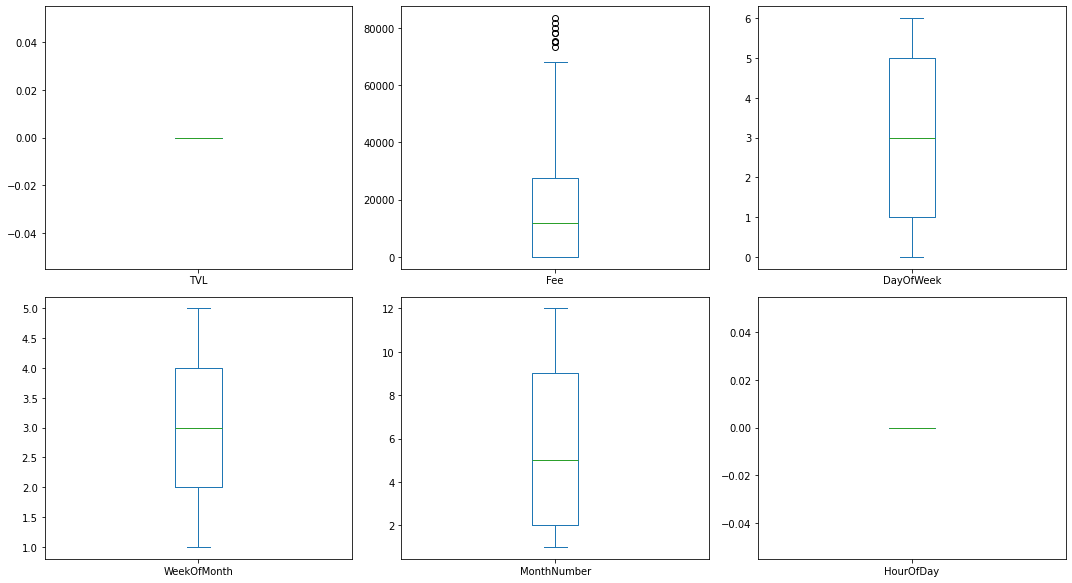

Original DataFrame shape: (445, 7)
DataFrame after removing outliers shape: (414, 7)


In [427]:
# Outliers part
plot_column_boxplots(df_looks_cleaned)
df_looks_cleaned = handle_outliers_mask(df_looks_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


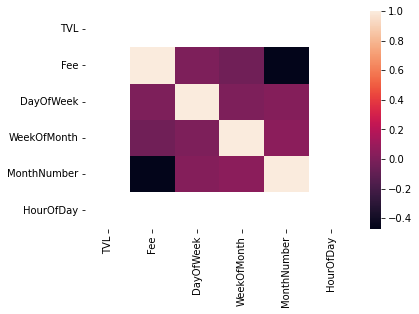

In [428]:
# Checking collinearity
corr_looks = collinearity(df_looks_cleaned)

In [429]:
df_looks_cleaned

,date,TVL,Fee,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
355,2023-01-01,0.0,56849.948829,6,1,1,0
356,2023-01-02,0.0,65855.946146,0,1,1,0
357,2023-01-03,0.0,60932.481125,1,1,1,0
358,2023-01-04,0.0,39159.057545,2,1,1,0
359,2023-01-05,0.0,53488.937465,3,1,1,0
...,...,...,...,...,...,...,...
795,2024-03-16,0.0,0.000000,5,3,3,0
796,2024-03-17,0.0,0.000000,6,3,3,0
797,2024-03-18,0.0,0.000000,0,3,3,0
798,2024-03-19,0.0,0.000000,1,3,3,0


# RBN (Fee, Supply, Staking,  Unique Addresses Missing)

In [430]:
# User Growth
df_rbn_userg = dune_get('user', 'date_day', 'total_users', 'https://api.dune.com/api/v1/query/2233767/results?')

In [431]:
# TVL
df_rbn_tvl = tvl_dfs.get('ribbon_tvl')
df_rbn_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_rbn_tvl['date'] = pd.to_datetime(df_rbn_tvl['date']).dt.date

In [432]:
# Yield
df_rbn_apy = yield_dfs.get('ribbon')

In [433]:
# Summerizing all to one dict for convenience
dict_rbn = get_dict('rbn', protocol_dict)
#dict_rbn = convert_date_columns(dict_rbn)

DataFrame named df_rbn_fee not found.
DataFrame named df_rbn_supply not found.
DataFrame named df_rbn_staking not found.
DataFrame named df_rbn_address not found.
DataFrame named df_rbn_trades not found.


In [434]:
# Combining
df_rbn = combine(dict_rbn)
df_rbn = df_rbn[df_rbn['date'] > cutoff_date]

In [435]:
df_rbn

,date,TVL,User Growth
624,2023-01-01,4.698053e+07,11176.0
625,2023-01-02,4.694194e+07,11178.0
626,2023-01-03,4.741279e+07,11179.0
627,2023-01-04,4.738489e+07,11181.0
628,2023-01-05,4.840356e+07,11191.0
...,...,...,...
1064,2024-03-17,1.589681e+07,NaN
1065,2024-03-18,1.648084e+07,NaN
1066,2024-03-19,1.586821e+07,NaN
1067,2024-03-20,1.447778e+07,NaN


In [436]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_rbn)
add_ts_columns(df_rbn)
checking_nas(df_rbn)

DataFrame Shape: (445, 3)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 624 to 1101
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         445 non-null    object 
 1   TVL          444 non-null    float64
 2   User Growth  111 non-null    float64
dtypes: float64(2), object(1)
memory usage: 13.9+ KB
None
Missing values over 10%: date           False
TVL            False
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
User Growth    False
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: bool
Missing values over 0%: date           False
TVL             True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool


In [437]:
# Cleaning process, na and duplicates part
df_rbn_cleaned = handle_nas(df_rbn)
df_rbn_cleaned = handle_duplicates(df_rbn_cleaned)

Duplicates:  624     False
625     False
626     False
627     False
628     False
        ...  
1064    False
1065    False
1066    False
1067    False
1101    False
Length: 445, dtype: bool


In [438]:
# Final check for any missing values
print("Final check for missing values:")
print(df_rbn_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


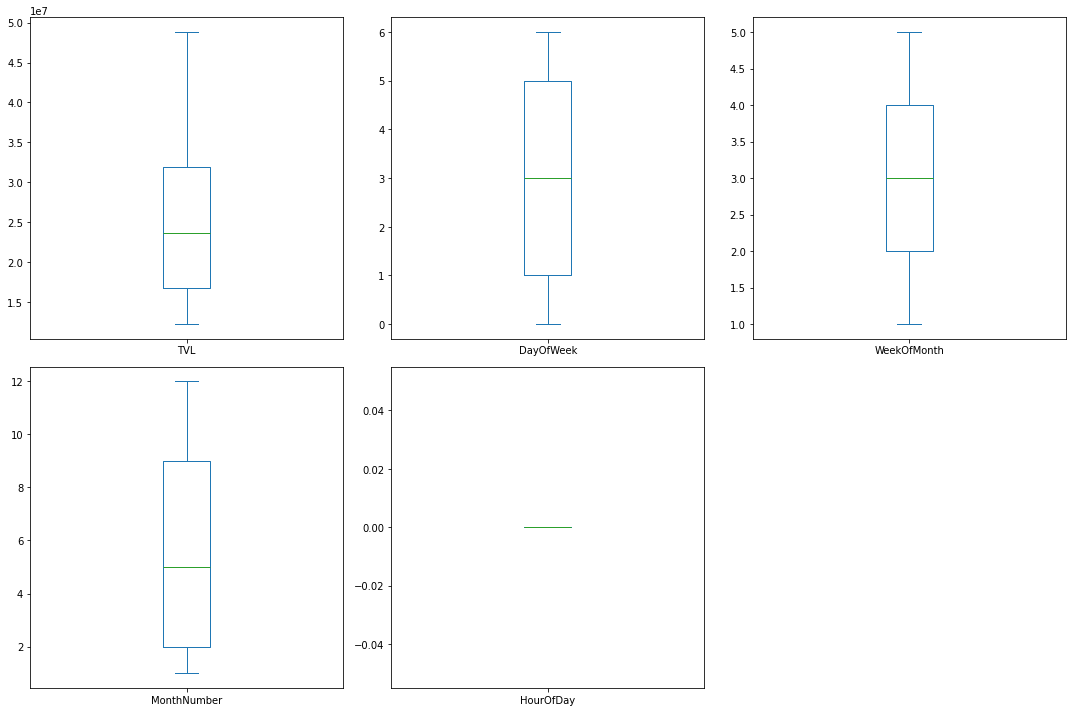

Original DataFrame shape: (445, 6)
DataFrame after removing outliers shape: (408, 6)


In [439]:
# Outliers part
plot_column_boxplots(df_rbn_cleaned)
df_rbn_cleaned = handle_outliers_mask(df_rbn_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


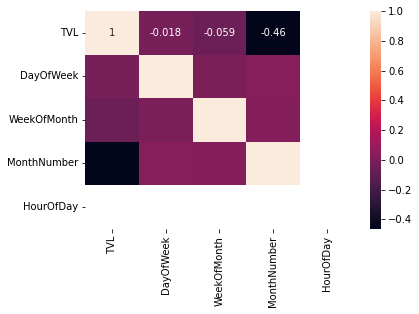

In [440]:
# Checking collinearity
corr_rbn = collinearity(df_rbn_cleaned)

In [441]:
df_rbn_cleaned

,date,TVL,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
624,2023-01-01,4.698053e+07,6,1,1,0
625,2023-01-02,4.694194e+07,0,1,1,0
626,2023-01-03,4.741279e+07,1,1,1,0
627,2023-01-04,4.738489e+07,2,1,1,0
628,2023-01-05,4.840356e+07,3,1,1,0
...,...,...,...,...,...,...
1064,2024-03-17,1.589681e+07,6,3,3,0
1065,2024-03-18,1.648084e+07,0,3,3,0
1066,2024-03-19,1.586821e+07,1,3,3,0
1067,2024-03-20,1.447778e+07,2,3,3,0


# Redacted Protocol (Fee, Staking, Unique Addresses, APY Missing

In [442]:
# Supply
df_rdt_supply = dune_get('supply', 'time', 'Circulating Supply', 'https://api.dune.com/api/v1/query/327714/results?')

In [443]:
# User Growth
df_rdt_userg = dune_get('user', 'Date', 'Redacted Users', 'https://api.dune.com/api/v1/query/313854/results?')

In [444]:
# TVL
df_rdt_tvl = tvl_dfs.get('redacted-protocol_tvl')
df_rdt_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_rdt_tvl['date'] = pd.to_datetime(df_rdt_tvl['date']).dt.date

In [445]:
# Summerizing all to one dict for convenience
dict_rdt = get_dict('rdt', protocol_dict)
dict_rdt = convert_date_columns(dict_rdt)

DataFrame named df_rdt_fee not found.
DataFrame named df_rdt_apy not found.
DataFrame named df_rdt_staking not found.
DataFrame named df_rdt_address not found.
DataFrame named df_rdt_trades not found.


In [446]:
# Combining
df_rdt = combine(dict_rdt)
df_rdt = df_rdt[df_rdt['date'] > cutoff_date]

In [447]:
df_rdt

,date,TVL,Supply,User Growth
381,2023-01-01,1.219349e+07,NaN,4362.0
382,2023-01-02,1.229955e+07,NaN,4351.0
383,2023-01-03,1.260568e+07,NaN,4342.0
384,2023-01-04,1.246862e+07,NaN,4334.0
385,2023-01-05,1.276272e+07,NaN,4330.0
...,...,...,...,...
821,2024-03-16,7.413092e+06,NaN,NaN
822,2024-03-17,6.814599e+06,NaN,NaN
823,2024-03-18,7.041730e+06,NaN,NaN
824,2024-03-19,6.783813e+06,NaN,NaN


In [448]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_rdt)
add_ts_columns(df_rdt)
checking_nas(df_rdt)

DataFrame Shape: (445, 4)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 381 to 825
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         445 non-null    object 
 1   TVL          445 non-null    float64
 2   Supply       0 non-null      float64
 3   User Growth  113 non-null    float64
dtypes: float64(3), object(1)
memory usage: 17.4+ KB
None
Missing values over 10%: date           False
TVL            False
Supply          True
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Supply         False
User Growth    False
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: bool
Missing values over 0%: date           False
TVL            False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
Hou

In [449]:
# Cleaning process, na and duplicates part
df_rdt_cleaned = handle_nas(df_rdt)
df_rdt_cleaned = handle_duplicates(df_rdt_cleaned)

Duplicates:  381    False
382    False
383    False
384    False
385    False
       ...  
821    False
822    False
823    False
824    False
825    False
Length: 445, dtype: bool


In [450]:
# Final check for any missing values
print("Final check for missing values:")
print(df_rdt_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


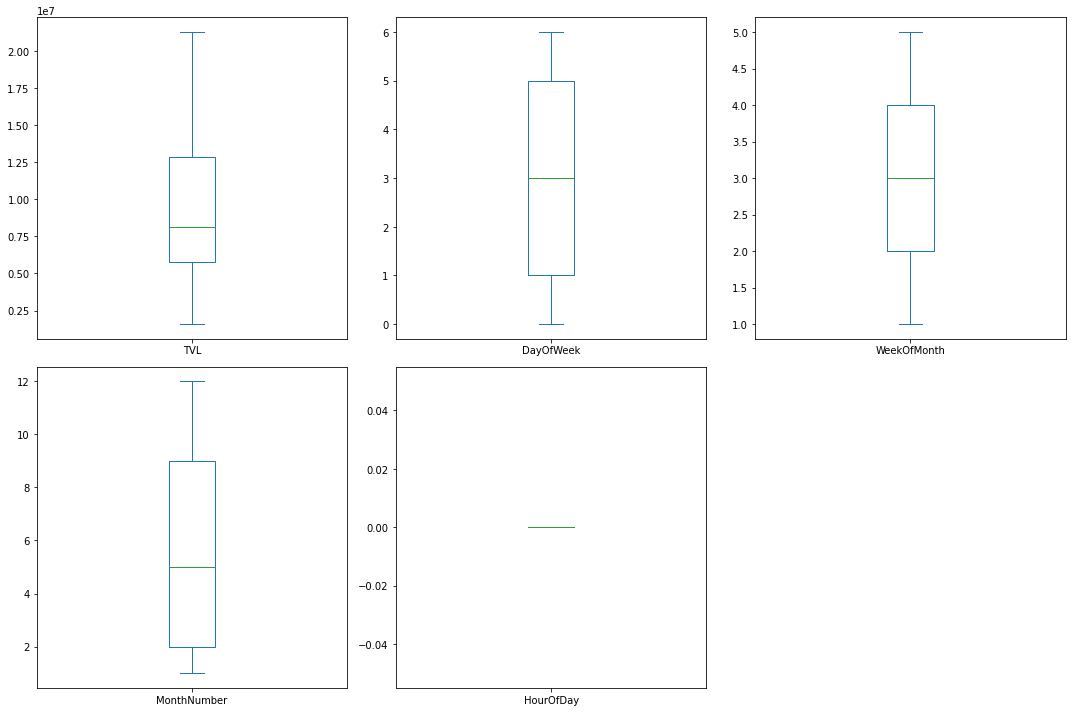

Original DataFrame shape: (445, 6)
DataFrame after removing outliers shape: (425, 6)


In [451]:
# Outliers part
plot_column_boxplots(df_rdt_cleaned)
df_rdt_cleaned = handle_outliers_mask(df_rdt_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


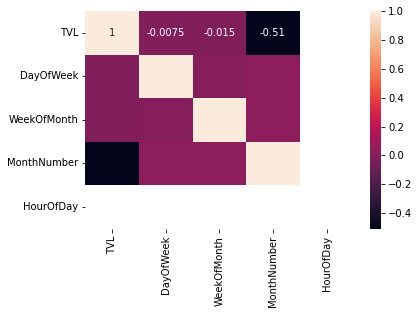

In [452]:
# Checking collinearity
corr_rdt = collinearity(df_rdt_cleaned)

In [453]:
df_rdt_cleaned

,date,TVL,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
381,2023-01-01,1.219349e+07,6,1,1,0
382,2023-01-02,1.229955e+07,0,1,1,0
383,2023-01-03,1.260568e+07,1,1,1,0
384,2023-01-04,1.246862e+07,2,1,1,0
385,2023-01-05,1.276272e+07,3,1,1,0
...,...,...,...,...,...,...
821,2024-03-16,7.413092e+06,5,3,3,0
822,2024-03-17,6.814599e+06,6,3,3,0
823,2024-03-18,7.041730e+06,0,3,3,0
824,2024-03-19,6.783813e+06,1,3,3,0


# DPX (Fee, APY, Staking, Unique Addresses Missing)

In [454]:
# TVL
#df_dpx_tvl = tvl_dfs.get('dopex_tvl')
#df_dpx_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
#df_dpx_tvl['date'] = pd.to_datetime(df_dpx_tvl['date']).dt.date

In [455]:
# User Growth
df_dpx_userg = dune_get('user', 'day', 'accumulate_user_count', 'https://api.dune.com/api/v1/query/2034578/results?')

In [456]:
# Supply
df_dpx_supply = dune_get('supply', 'date', 'total', 'https://api.dune.com/api/v1/query/1222867/results?')

In [457]:
# Summerizing all to one dict for convenience
dict_dpx = get_dict('dpx', protocol_dict)
dict_dpx = convert_date_columns(dict_dpx)

DataFrame named df_dpx_tvl not found.
DataFrame named df_dpx_fee not found.
DataFrame named df_dpx_apy not found.
DataFrame named df_dpx_staking not found.
DataFrame named df_dpx_address not found.
DataFrame named df_dpx_trades not found.


In [458]:
# Combining
df_dpx = combine(dict_dpx)
df_dpx = df_dpx[df_dpx['date'] > cutoff_date]

In [459]:
df_dpx

,date,Supply,User Growth
118,2023-01-02,445352.571522,38224.0
119,2023-01-02,445352.571522,38224.0
120,2023-01-09,445375.495233,42629.0
121,2023-01-16,445435.263903,46090.0
122,2023-01-23,445449.866160,50233.0
...,...,...,...
673,2024-02-12,NaN,151896.0
674,2024-02-13,NaN,151898.0
675,2024-02-14,NaN,151899.0
676,2024-02-15,NaN,151900.0


In [460]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_dpx)
add_ts_columns(df_dpx)
checking_nas(df_dpx)

DataFrame Shape: (414, 3)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 118 to 677
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         414 non-null    object 
 1   Supply       19 non-null     float64
 2   User Growth  414 non-null    float64
dtypes: float64(2), object(1)
memory usage: 12.9+ KB
None
Missing values over 10%: date           False
Supply          True
User Growth    False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
Supply         False
User Growth     True
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: bool
Missing values over 0%: date           False
User Growth    False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool


In [461]:
# Cleaning process, na and duplicates part
df_dpx_cleaned = handle_nas(df_dpx)
df_dpx_cleaned = handle_duplicates(df_dpx_cleaned)

Duplicates:  118    False
119     True
120    False
121    False
122    False
       ...  
673    False
674    False
675    False
676    False
677    False
Length: 414, dtype: bool


In [462]:
# Final check for any missing values
print("Final check for missing values:")
print(df_dpx_cleaned.isnull().sum())

Final check for missing values:
date           0
User Growth    0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


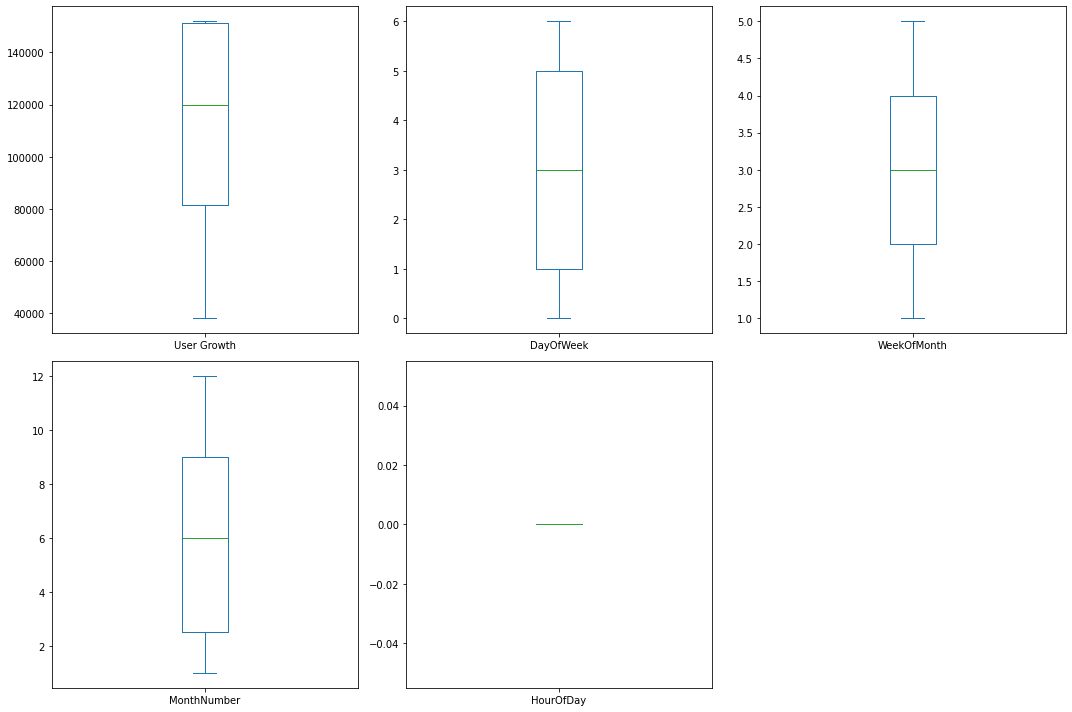

Original DataFrame shape: (407, 6)
DataFrame after removing outliers shape: (397, 6)


In [463]:
# Outliers part
plot_column_boxplots(df_dpx_cleaned)
df_dpx_cleaned = handle_outliers_mask(df_dpx_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


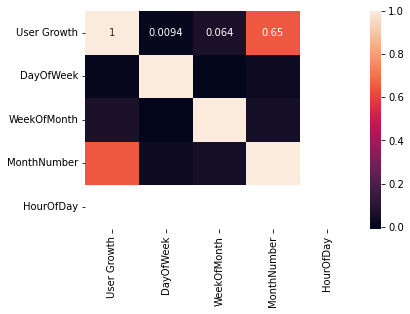

In [464]:
# Checking collinearity
corr_dpx = collinearity(df_dpx_cleaned)

In [465]:
df_dpx_cleaned

,date,User Growth,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
118,2023-01-02,38224.0,0,1,1,0
120,2023-01-09,42629.0,0,2,1,0
121,2023-01-16,46090.0,0,3,1,0
122,2023-01-23,50233.0,0,4,1,0
124,2023-01-30,53626.0,0,5,1,0
...,...,...,...,...,...,...
673,2024-02-12,151896.0,0,2,2,0
674,2024-02-13,151898.0,1,2,2,0
675,2024-02-14,151899.0,2,2,2,0
676,2024-02-15,151900.0,3,3,2,0


# KUJI (Only TVL avaliable)

In [466]:
# TVL
df_kuji_tvl = tvl_dfs.get('kujira-protocol_tvl')
df_kuji_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_kuji_tvl['date'] = pd.to_datetime(df_kuji_tvl['date']).dt.date

# POLY ( Supply, APY, Staking, User Growth Missing)

In [467]:
# TVL
df_poly_tvl = tvl_dfs.get('polynomial-protocol_tvl')
df_poly_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_poly_tvl['date'] = pd.to_datetime(df_poly_tvl['date']).dt.date

In [468]:
# Unique Addresses
df_poly_address = dune_get('addr', 'fst_date', 'cum_from', 'https://api.dune.com/api/v1/query/600726/results?')

In [469]:
# Fee
# df_poly_fee = dune_get('fee', 'time', 'total_fees', 'https://api.dune.com/api/v1/query/2830219/results?')

In [470]:
# Summerizing all to one dict for convenience
dict_poly = get_dict('poly', protocol_dict)
dict_poly = convert_date_columns(dict_poly)

DataFrame named df_poly_fee not found.
DataFrame named df_poly_apy not found.
DataFrame named df_poly_supply not found.
DataFrame named df_poly_staking not found.
DataFrame named df_poly_userg not found.
DataFrame named df_poly_trades not found.


In [471]:
# Combining
df_poly = combine(dict_poly)
df_poly = df_poly[df_poly['date'] > cutoff_date]
df_poly

,date,TVL,Unique Addresses
271,2023-01-01,1.057397e+06,NaN
272,2023-01-02,1.053340e+06,NaN
273,2023-01-03,1.083758e+06,NaN
274,2023-01-04,1.112931e+06,NaN
275,2023-01-05,1.183227e+06,NaN
...,...,...,...
712,2024-03-17,5.728941e+06,NaN
713,2024-03-18,5.797813e+06,NaN
714,2024-03-19,5.795348e+06,NaN
715,2024-03-20,6.180639e+06,NaN


In [472]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_poly)
add_ts_columns(df_poly)
checking_nas(df_poly)

DataFrame Shape: (446, 3)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 271 to 716
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              446 non-null    object 
 1   TVL               446 non-null    float64
 2   Unique Addresses  0 non-null      float64
dtypes: float64(2), object(1)
memory usage: 13.9+ KB
None
Missing values over 10%: date                False
TVL                 False
Unique Addresses     True
DayOfWeek           False
WeekOfMonth         False
MonthNumber         False
HourOfDay           False
dtype: bool
Missing values under 10%: date                 True
TVL                  True
Unique Addresses    False
DayOfWeek            True
WeekOfMonth          True
MonthNumber          True
HourOfDay            True
dtype: bool
Missing values over 0%: date           False
TVL            False
DayOfWeek      False
WeekOfMonth    False
MonthNumber  

In [473]:
# Cleaning process, na and duplicates part
df_poly_cleaned = handle_nas(df_poly)
df_poly_cleaned = handle_duplicates(df_poly_cleaned)

Duplicates:  271    False
272    False
273    False
274    False
275    False
       ...  
712    False
713    False
714    False
715    False
716    False
Length: 446, dtype: bool


In [474]:
# Final check for any missing values
print("Final check for missing values:")
print(df_poly_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


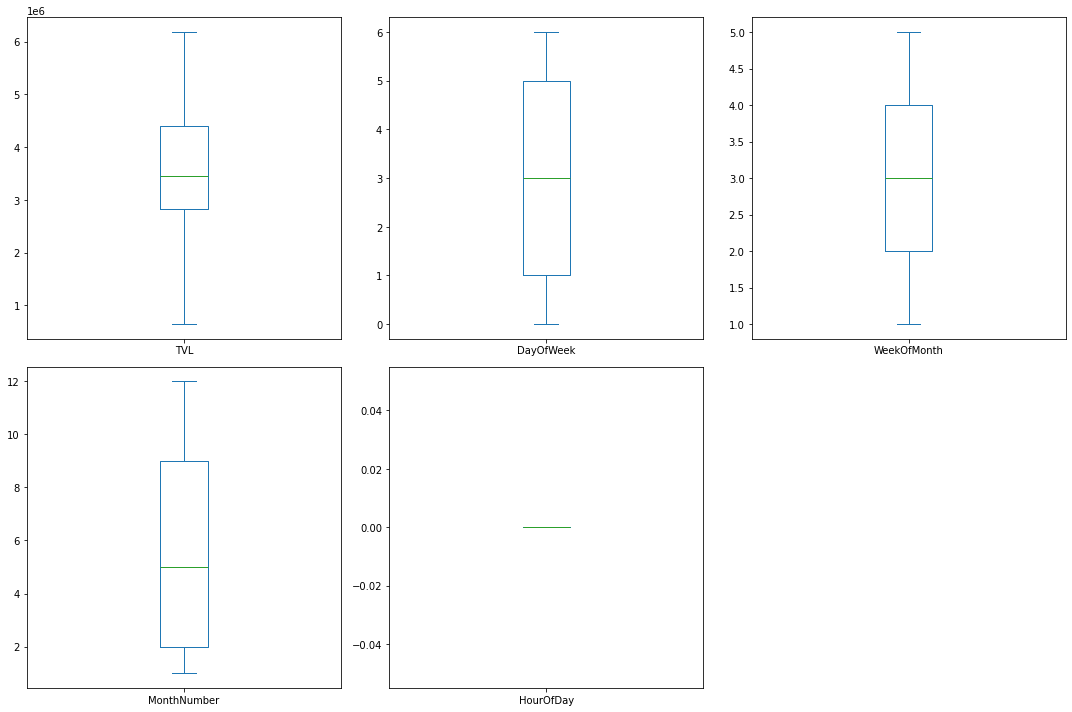

Original DataFrame shape: (446, 6)
DataFrame after removing outliers shape: (417, 6)


In [475]:
# Outliers part
plot_column_boxplots(df_poly_cleaned)
df_poly_cleaned = handle_outliers_mask(df_poly_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


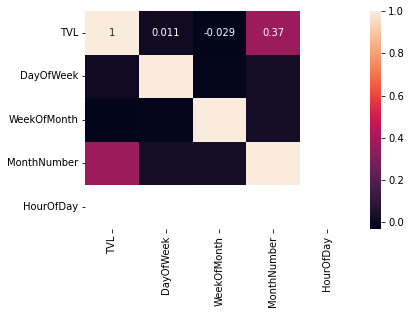

In [476]:
# Checking collinearity
corr_poly = collinearity(df_poly_cleaned)

In [477]:
df_poly_cleaned

,date,TVL,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
274,2023-01-04,1.112931e+06,2,1,1,0
275,2023-01-05,1.183227e+06,3,1,1,0
276,2023-01-06,1.198421e+06,4,1,1,0
277,2023-01-07,1.173219e+06,5,1,1,0
278,2023-01-08,1.224778e+06,6,2,1,0
...,...,...,...,...,...,...
710,2024-03-15,5.582523e+06,4,3,3,0
711,2024-03-16,5.773111e+06,5,3,3,0
712,2024-03-17,5.728941e+06,6,3,3,0
713,2024-03-18,5.797813e+06,0,3,3,0


# GMX

In [478]:
# TVL
df_gmx_tvl = tvl_dfs.get('gmx_tvl')
df_gmx_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_gmx_tvl['date'] = pd.to_datetime(df_gmx_tvl['date']).dt.date

In [479]:
# Fee
df_gmx_fee = fee_dfs.get('gmx')

In [480]:
# Yield
df_gmxv1_apy = yield_dfs.get('gmx-v1')
df_gmxv1_apy.rename(columns={'APY': 'GMX V1 APY'}, inplace=True)
df_gmxv2_apy = yield_dfs.get('gmx-v2')
df_gmxv2_apy.rename(columns={'APY': 'GMX V2 APY'}, inplace=True)
df_gmx_apy = pd.merge(df_gmxv1_apy, df_gmxv2_apy, on='date', how='outer')

In [481]:
# Supply
# df_gmx_supply = dune_get('supply', 'evt_block_time', '_col1', 'https://api.dune.com/api/v1/query/2421396/results?')

In [482]:
# Staking
df_gmx_staking = dune_get('staking','time_scale', 'gmx_stake', 'https://api.dune.com/api/v1/query/1036839/results?')

In [483]:
# Unique Addresses
df_gmx_address = dune_get('addr', 'Date', 'Holders', 'https://api.dune.com/api/v1/query/1191425/results?')

In [484]:
# User Growth
# df_gmxv1_userg = dune_get('user', 'time', 'v1_users', 'https://api.dune.com/api/v1/query/3183273/results?')
# df_gmxv1_userg.rename(columns={'User Growth': 'GMX V1 User Growth'}, inplace=True)
# df_gmxv2_userg = dune_get('user', 'time', 'v2_users', 'https://api.dune.com/api/v1/query/3183273/results?')
# df_gmxv2_userg.rename(columns={'User Growth': 'GMX V2 User Growth'}, inplace=True)
# df_gmx_userg = pd.merge(df_gmxv1_userg, df_gmxv2_userg, on = 'date', how = 'outer')

In [485]:
# Summerizing all to one dict for convenience
dict_gmx = get_dict('gmx', protocol_dict)
dict_gmx = convert_date_columns(dict_gmx)

DataFrame named df_gmx_supply not found.
DataFrame named df_gmx_userg not found.
DataFrame named df_gmx_trades not found.


In [486]:
# Combining
df_gmx = combine(dict_gmx)
df_gmx = df_gmx[df_gmx['date'] > cutoff_date]
df_gmx

,date,TVL,Fee,GMX V1 APY,GMX V2 APY,Staking,Unique Addresses
487,2023-01-01,4.615744e+08,77653.775378,10.26147,NaN,NaN,3852.0
488,2023-01-02,4.622452e+08,150068.991038,10.31952,NaN,NaN,3854.0
489,2023-01-03,4.646469e+08,103902.404636,10.48182,NaN,NaN,3852.0
490,2023-01-04,4.623293e+08,383253.407491,6.09673,NaN,NaN,3851.0
491,2023-01-05,4.579346e+08,115294.651323,6.03293,NaN,NaN,3857.0
...,...,...,...,...,...,...,...
928,2024-03-17,6.290931e+08,127139.000000,5.28659,0.32797,6416.0,NaN
929,2024-03-18,6.391377e+08,177123.000000,5.94820,0.32797,17963.0,NaN
930,2024-03-19,6.292060e+08,142725.000000,5.88430,0.36911,26703.0,NaN
931,2024-03-20,6.056934e+08,NaN,6.58800,0.36911,NaN,NaN


In [487]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_gmx)
add_ts_columns(df_gmx)
checking_nas(df_gmx)

DataFrame Shape: (446, 7)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 487 to 932
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              446 non-null    object 
 1   TVL               446 non-null    float64
 2   Fee               444 non-null    float64
 3   GMX V1 APY        444 non-null    float64
 4   GMX V2 APY        163 non-null    float64
 5   Staking           366 non-null    float64
 6   Unique Addresses  114 non-null    float64
dtypes: float64(6), object(1)
memory usage: 27.9+ KB
None
Missing values over 10%: date                False
TVL                 False
Fee                 False
GMX V1 APY          False
GMX V2 APY           True
Staking              True
Unique Addresses     True
DayOfWeek           False
WeekOfMonth         False
MonthNumber         False
HourOfDay           False
dtype: bool
Missing values under 10%: date                 Tr

In [488]:
# Cleaning process, na and duplicates part
df_gmx_cleaned = handle_nas(df_gmx)
df_gmx_cleaned = handle_duplicates(df_gmx_cleaned)

Duplicates:  487    False
488    False
489    False
490    False
491    False
       ...  
928    False
929    False
930    False
931    False
932    False
Length: 446, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'


In [489]:
# Final check for any missing values
print("Final check for missing values:")
print(df_gmx_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
GMX V1 APY     0
Staking        0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


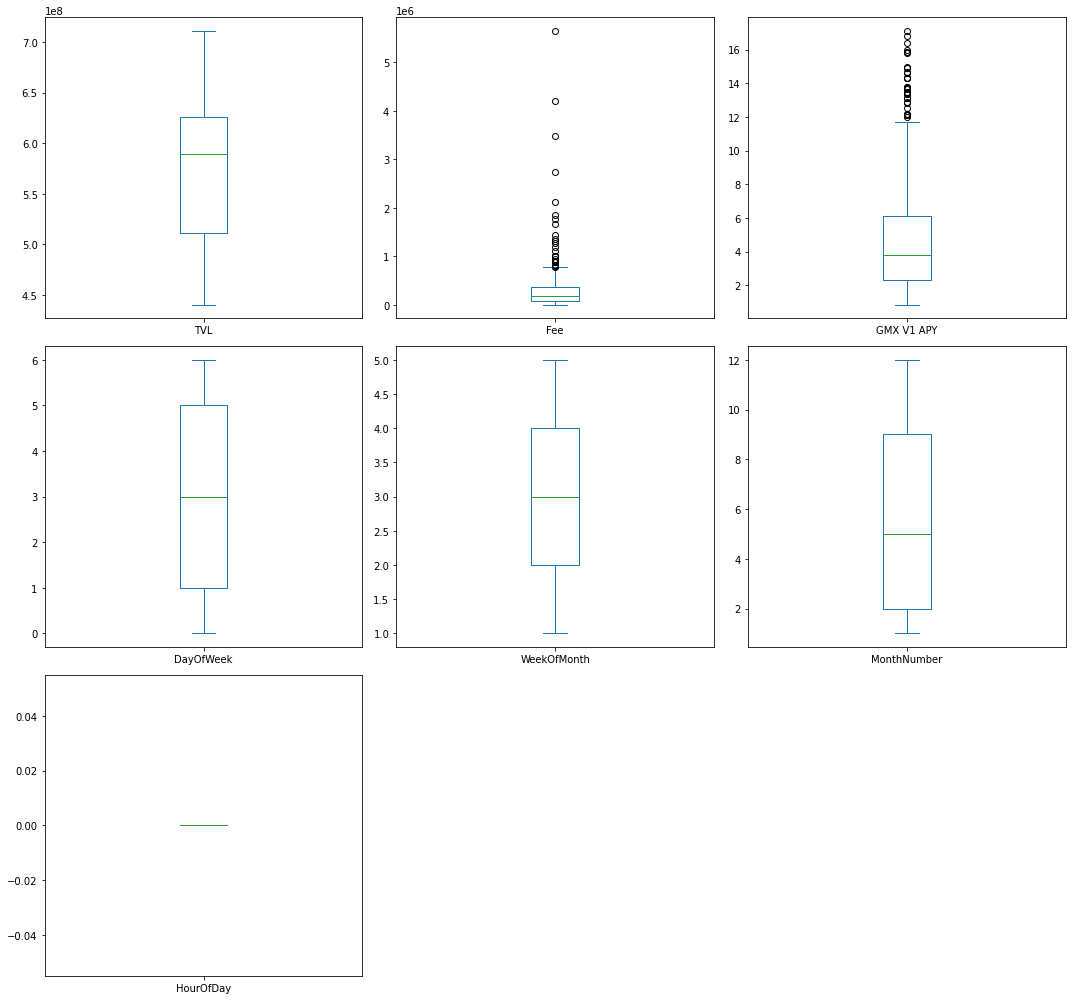

Original DataFrame shape: (446, 9)
DataFrame after removing outliers shape: (442, 9)


In [490]:
# Outliers part
plot_column_boxplots(df_gmx_cleaned)
df_gmx_cleaned = handle_outliers_mask(df_gmx_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


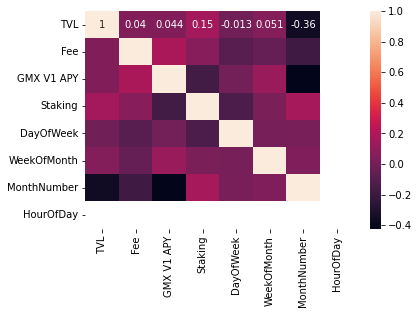

In [491]:
# Checking collinearity
corr_gmx = collinearity(df_gmx_cleaned)

In [492]:
df_gmx_cleaned

,date,TVL,Fee,GMX V1 APY,Staking,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
487,2023-01-01,4.615744e+08,77653.775378,10.26147,0,6,1,1,0
488,2023-01-02,4.622452e+08,150068.991038,10.31952,0,0,1,1,0
489,2023-01-03,4.646469e+08,103902.404636,10.48182,0,1,1,1,0
490,2023-01-04,4.623293e+08,383253.407491,6.09673,0,2,1,1,0
491,2023-01-05,4.579346e+08,115294.651323,6.03293,0,3,1,1,0
...,...,...,...,...,...,...,...,...,...
928,2024-03-17,6.290931e+08,127139.000000,5.28659,6416.0,6,3,3,0
929,2024-03-18,6.391377e+08,177123.000000,5.94820,17963.0,0,3,3,0
930,2024-03-19,6.292060e+08,142725.000000,5.88430,26703.0,1,3,3,0
931,2024-03-20,6.056934e+08,142725.000000,6.58800,26703.0,2,3,3,0


# FRX

In [493]:
# TVL
df_frx_tvl = tvl_dfs.get('frax-finance_tvl')
df_frx_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_frx_tvl['date'] = pd.to_datetime(df_frx_tvl['date']).dt.date

In [494]:
# Fee
df_frx_fee = fee_dfs.get('frax-finance')

In [495]:
# Yield
df_frx_apy = yield_dfs.get('frax')

In [496]:
# Supply
# df_frx_supply = dune_get('supply', 'day', 'supply', 'https://api.dune.com/api/v1/query/2628014/results?')

In [497]:
# Staking
df_frx_staking = dune_get('staking', 'time', 'Frax', 'https://api.dune.com/api/v1/query/96263/results?')

In [498]:
# Unique Addresses
df_frx_address = dune_get('addr', 'dt', 'num_unique_holders', 'https://api.dune.com/api/v1/query/1858526/results?')

In [499]:
# Group by day
grouped = df_frx_address.groupby(pd.Grouper(key='date'))
sum_by_date = grouped['Unique Addresses'].sum()
df_frx_address = pd.DataFrame(sum_by_date)

In [500]:
# User Growth
df_frx_userg = dune_get('user', 'date', 'total_users', 'https://api.dune.com/api/v1/query/916405/results?')

In [501]:
# Summerizing all to one dict for convenience
dict_frx = get_dict('frx', protocol_dict)
dict_frx = convert_date_columns(dict_frx)

DataFrame named df_frx_supply not found.
DataFrame named df_frx_trades not found.
'date' column not found in DataFrame associated with key 'address'


In [502]:
# Combining
df_frx = combine(dict_frx)
df_frx = df_frx[df_frx['date'] > cutoff_date]
df_frx

,date,TVL,Fee,APY,Staking,Unique Addresses,User Growth
745,2023-01-01,1.224407e+09,4745.0600,34.16277,46754.424273,133.0,29739.0
746,2023-01-02,1.223816e+09,22880.7300,34.82932,46870.974375,163.0,29752.0
747,2023-01-03,1.230561e+09,5432.2500,42.70256,47403.800229,145.0,29771.0
748,2023-01-04,1.230690e+09,5369.3700,49.65212,47750.187774,171.0,29782.0
749,2023-01-05,1.236650e+09,51287.7605,53.83603,49040.614647,129.0,29797.0
...,...,...,...,...,...,...,...
1186,2024-03-17,1.332955e+09,13415.0000,0.00000,NaN,NaN,NaN
1187,2024-03-18,1.379941e+09,10768.0000,0.00000,NaN,NaN,NaN
1188,2024-03-19,1.330604e+09,29829.0000,0.00000,NaN,NaN,NaN
1189,2024-03-20,1.291657e+09,NaN,0.00000,NaN,NaN,NaN


In [503]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_frx)
add_ts_columns(df_frx)
checking_nas(df_frx)

DataFrame Shape: (446, 7)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 745 to 1190
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              446 non-null    object 
 1   TVL               446 non-null    float64
 2   Fee               444 non-null    float64
 3   APY               446 non-null    float64
 4   Staking           114 non-null    float64
 5   Unique Addresses  62 non-null     float64
 6   User Growth       106 non-null    float64
dtypes: float64(6), object(1)
memory usage: 27.9+ KB
None
Missing values over 10%: date                False
TVL                 False
Fee                 False
APY                 False
Staking              True
Unique Addresses     True
User Growth          True
DayOfWeek           False
WeekOfMonth         False
MonthNumber         False
HourOfDay           False
dtype: bool
Missing values under 10%: date                 T

In [504]:
# Cleaning process, na and duplicates part
df_frx_cleaned = handle_nas(df_frx)
df_frx_cleaned = handle_duplicates(df_frx_cleaned)

Duplicates:  745     False
746     False
747     False
748     False
749     False
        ...  
1186    False
1187    False
1188    False
1189    False
1190    False
Length: 446, dtype: bool


In [505]:
# Final check for any missing values
print("Final check for missing values:")
print(df_frx_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
APY            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


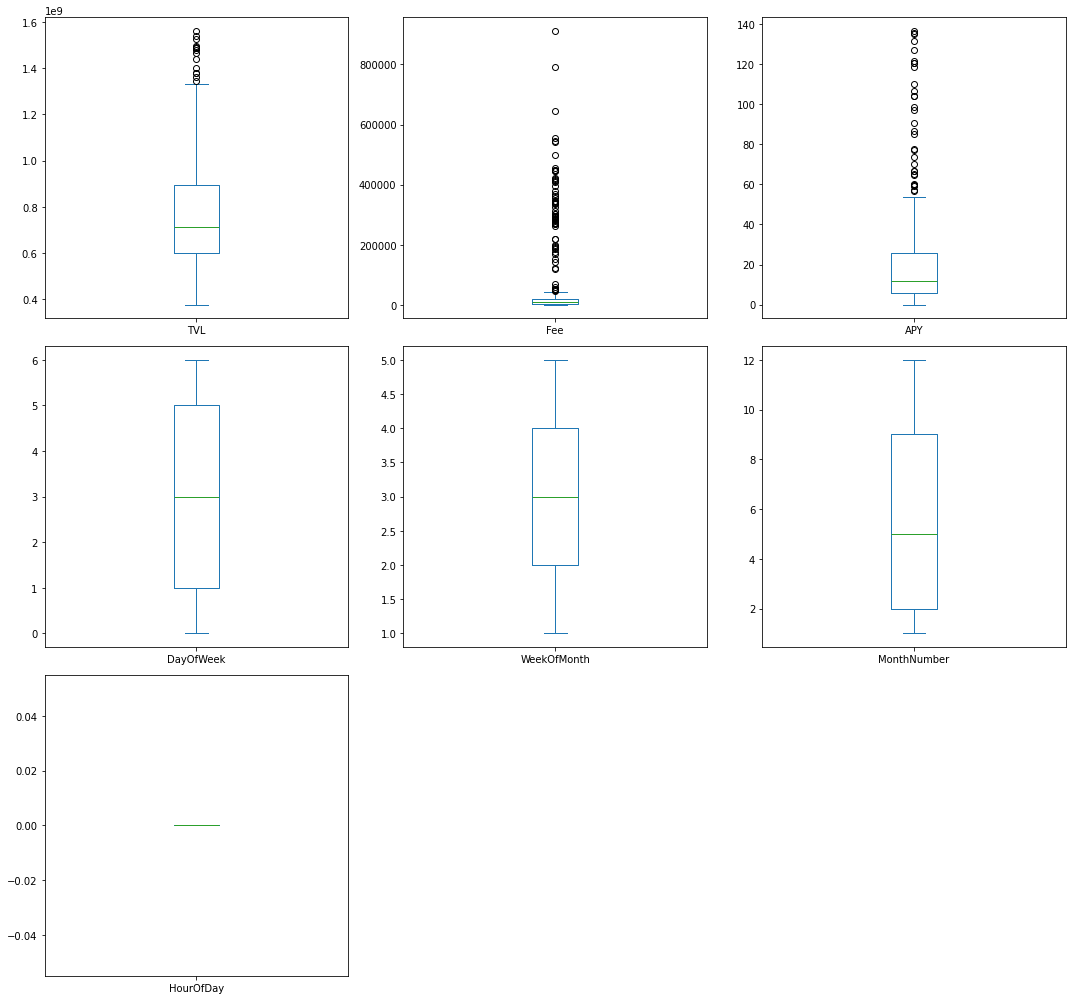

Original DataFrame shape: (446, 8)
DataFrame after removing outliers shape: (429, 8)


In [506]:
# Outliers part
plot_column_boxplots(df_frx_cleaned)
df_frx_cleaned = handle_outliers_mask(df_frx_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


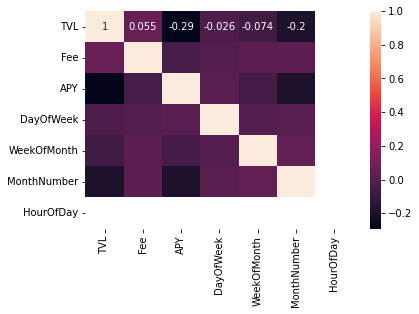

In [507]:
# Checking collinearity
corr_frx = collinearity(df_frx_cleaned)

In [508]:
df_frx_cleaned

,date,TVL,Fee,APY,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
745,2023-01-01,1.224407e+09,4745.0600,34.16277,6,1,1,0
746,2023-01-02,1.223816e+09,22880.7300,34.82932,0,1,1,0
747,2023-01-03,1.230561e+09,5432.2500,42.70256,1,1,1,0
748,2023-01-04,1.230690e+09,5369.3700,49.65212,2,1,1,0
749,2023-01-05,1.236650e+09,51287.7605,53.83603,3,1,1,0
...,...,...,...,...,...,...,...,...
1186,2024-03-17,1.332955e+09,13415.0000,0.00000,6,3,3,0
1187,2024-03-18,1.379941e+09,10768.0000,0.00000,0,3,3,0
1188,2024-03-19,1.330604e+09,29829.0000,0.00000,1,3,3,0
1189,2024-03-20,1.291657e+09,29829.0000,0.00000,2,3,3,0


# CVX (Unique Addresses, User Growth Missing)

In [509]:
# TVL
df_cvx_tvl = tvl_dfs.get('convex-finance_tvl')
df_cvx_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_cvx_tvl['date'] = pd.to_datetime(df_cvx_tvl['date']).dt.date

In [510]:
# Fee
df_cvx_fee = fee_dfs.get('convex-finance')

In [511]:
# Yield
df_cvx_apy = yield_dfs.get('convex-finance')

In [512]:
# Supply
df_cvx_supply = dune_get('supply', 'time', 'circ_supply', 'https://api.dune.com/api/v1/query/977681/results?')

In [513]:
# Group by day
grouped = df_cvx_supply.groupby(pd.Grouper(key='date'))
sum_by_date = grouped['Supply'].sum()
df_cvx_supply = pd.DataFrame(sum_by_date)

In [514]:
# Staking
df_cvx_staking = dune_get('staking', 'evt_date', 'Convex', 'https://api.dune.com/api/v1/query/1854989/results?')

In [515]:
# Summerizing all to one dict for convenience
dict_cvx = get_dict('cvx', protocol_dict)
dict_cvx = convert_date_columns(dict_cvx)

DataFrame named df_cvx_address not found.
DataFrame named df_cvx_userg not found.
DataFrame named df_cvx_trades not found.
'date' column not found in DataFrame associated with key 'supply'


In [516]:
# Combining
df_cvx = combine(dict_cvx)
df_cvx = df_cvx[df_cvx['date'] > cutoff_date]
df_cvx

,date,TVL,Fee,APY,Supply,Staking
593,2023-01-01,2.971257e+09,46520.437204,NaN,2.589780e+09,NaN
594,2023-01-02,3.006946e+09,46710.299855,NaN,2.877772e+09,1.864815e+07
595,2023-01-03,3.031137e+09,47056.673264,NaN,2.877801e+09,NaN
596,2023-01-04,3.035321e+09,46525.538744,NaN,2.014592e+09,1.864815e+07
597,2023-01-05,3.069953e+09,48041.849134,NaN,8.634414e+08,1.864815e+07
...,...,...,...,...,...,...
1034,2024-03-18,1.786607e+09,31247.000000,3.29000,NaN,NaN
1035,2024-03-19,1.745430e+09,31858.000000,6.10000,NaN,NaN
1036,2024-03-20,1.589110e+09,NaN,5.46000,NaN,NaN
1037,2024-03-20,1.599490e+09,NaN,5.46000,NaN,NaN


In [517]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_cvx)
add_ts_columns(df_cvx)
checking_nas(df_cvx)

DataFrame Shape: (446, 6)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 593 to 1039
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     446 non-null    object 
 1   TVL      445 non-null    float64
 2   Fee      444 non-null    float64
 3   APY      183 non-null    float64
 4   Supply   383 non-null    float64
 5   Staking  49 non-null     float64
dtypes: float64(5), object(1)
memory usage: 24.4+ KB
None
Missing values over 10%: date           False
TVL            False
Fee            False
APY             True
Supply          True
Staking         True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Fee             True
APY            False
Supply         False
Staking        False
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: 

In [518]:
# Cleaning process, na and duplicates part
df_cvx_cleaned = handle_nas(df_cvx)
df_cvx_cleaned = handle_duplicates(df_cvx_cleaned)

Duplicates:  593     False
594     False
595     False
596     False
597     False
        ...  
1034    False
1035    False
1036    False
1037    False
1039    False
Length: 446, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'


In [519]:
# Final check for any missing values
print("Final check for missing values:")
print(df_cvx_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
APY            0
Supply         0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


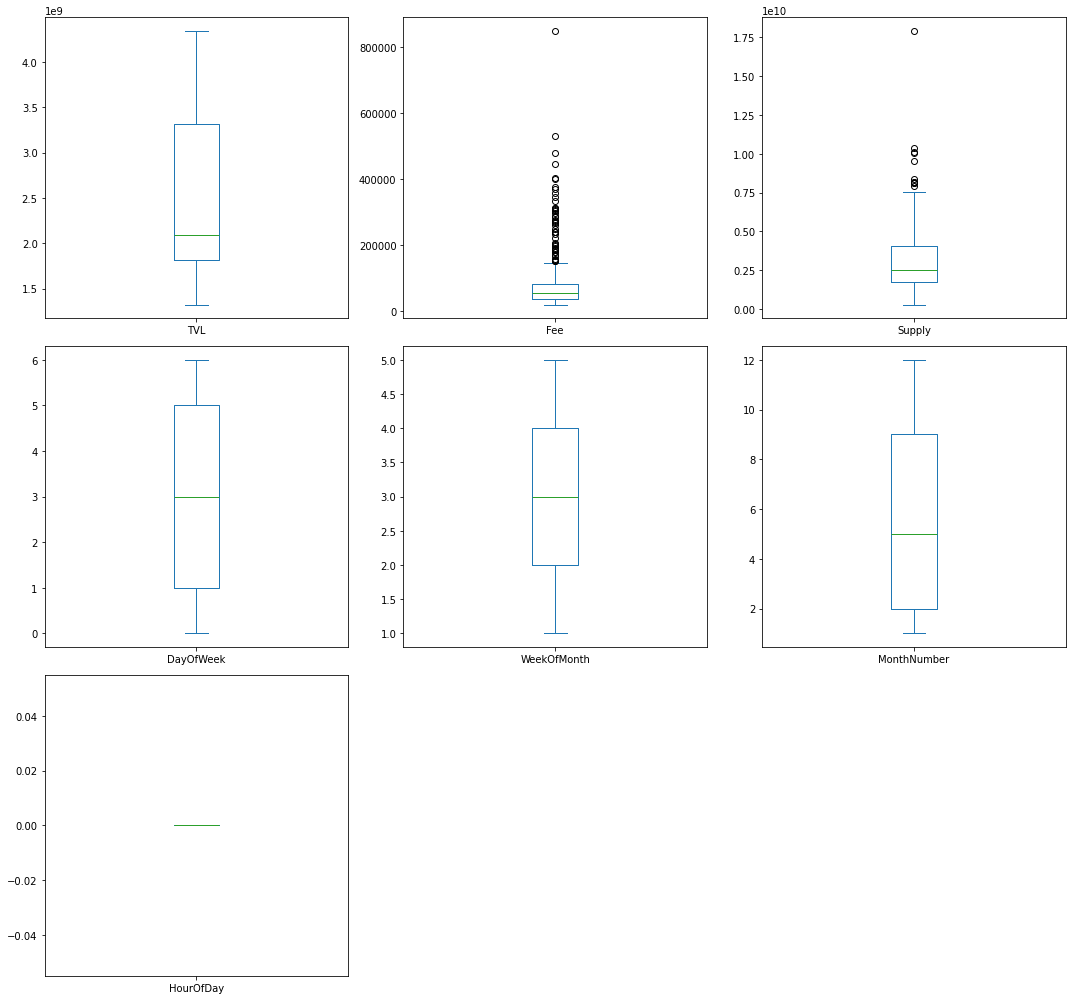

Original DataFrame shape: (446, 9)
DataFrame after removing outliers shape: (412, 9)


In [520]:
# Outliers part
plot_column_boxplots(df_cvx_cleaned)
df_cvx_cleaned = handle_outliers_mask(df_cvx_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


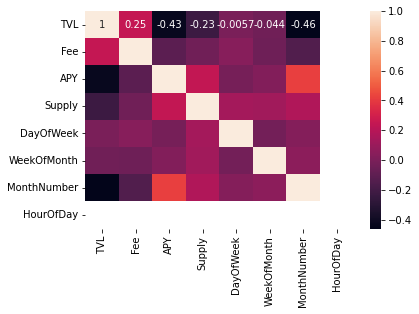

In [521]:
# Checking collinearity
corr_cvx = collinearity(df_cvx_cleaned)

In [522]:
df_cvx_cleaned

,date,TVL,Fee,APY,Supply,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
593,2023-01-01,2.971257e+09,46520.437204,0,2.589780e+09,6,1,1,0
594,2023-01-02,3.006946e+09,46710.299855,0,2.877772e+09,0,1,1,0
595,2023-01-03,3.031137e+09,47056.673264,0,2.877801e+09,1,1,1,0
596,2023-01-04,3.035321e+09,46525.538744,0,2.014592e+09,2,1,1,0
597,2023-01-05,3.069953e+09,48041.849134,0,8.634414e+08,3,1,1,0
...,...,...,...,...,...,...,...,...,...
1034,2024-03-18,1.786607e+09,31247.000000,3.29,2.544263e+09,0,3,3,0
1035,2024-03-19,1.745430e+09,31858.000000,6.1,2.544263e+09,1,3,3,0
1036,2024-03-20,1.589110e+09,31858.000000,5.46,2.544263e+09,2,3,3,0
1037,2024-03-20,1.599490e+09,31858.000000,5.46,2.544263e+09,2,3,3,0


# CRV (Unique Addresses Missing)

In [523]:
# TVL
df_crv_tvl = tvl_dfs.get('curve-finance_tvl')
df_crv_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_crv_tvl['date'] = pd.to_datetime(df_crv_tvl['date']).dt.date

In [524]:
# Fee
df_crv_fee = fee_dfs.get('curve-finance')

In [525]:
# Yield
df_crv_apy = yield_dfs.get('curve-dex')

In [526]:
# Supply
df_crv_supply = dune_get('supply', 'day', 'total_supply', 'https://api.dune.com/api/v1/query/1150375/results?')

In [527]:
# Staking
df_crv_staking = dune_get('staking', 'evt_date', 'Curve', 'https://api.dune.com/api/v1/query/1854989/results?')

In [528]:
# User Growth
df_crv_userg = dune_get('user', 'date', 'total_users', 'https://api.dune.com/api/v1/query/15178/results?')

In [529]:
# Summerizing all to one dict for convenience
dict_crv = get_dict('crv', protocol_dict)
dict_crv = convert_date_columns(dict_crv)

DataFrame named df_crv_address not found.
DataFrame named df_crv_trades not found.


In [530]:
# Combining
df_crv = combine(dict_crv)
df_crv = df_crv[df_crv['date'] > cutoff_date]
df_crv

,date,TVL,Fee,APY,Supply,Staking,User Growth
1057,2023-01-01,3.600588e+09,27800.211683,NaN,1.878167e+09,NaN,82048.0
1058,2023-01-02,3.605495e+09,33613.338931,NaN,1.878674e+09,93058.044797,82069.0
1059,2023-01-03,3.632737e+09,55004.926433,NaN,1.879188e+09,NaN,82089.0
1060,2023-01-04,3.640003e+09,76006.190360,NaN,1.879670e+09,93058.044797,82114.0
1061,2023-01-05,3.663339e+09,81454.465742,NaN,1.880368e+09,93058.044797,82134.0
...,...,...,...,...,...,...,...
1498,2024-03-17,2.597215e+09,457757.000000,0.0,NaN,NaN,NaN
1499,2024-03-18,2.644326e+09,278560.000000,0.0,NaN,NaN,NaN
1500,2024-03-19,2.457643e+09,745363.000000,0.0,NaN,NaN,NaN
1501,2024-03-20,2.503237e+09,NaN,0.0,NaN,NaN,NaN


In [531]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_crv)
add_ts_columns(df_crv)
checking_nas(df_crv)

DataFrame Shape: (446, 7)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 1057 to 1502
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         446 non-null    object 
 1   TVL          446 non-null    float64
 2   Fee          444 non-null    float64
 3   APY          137 non-null    float64
 4   Supply       430 non-null    float64
 5   Staking      49 non-null     float64
 6   User Growth  111 non-null    float64
dtypes: float64(6), object(1)
memory usage: 27.9+ KB
None
Missing values over 10%: date           False
TVL            False
Fee            False
APY             True
Supply         False
Staking         True
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Fee             True
APY            False
Supply          True
Staking        F

In [532]:
# Cleaning process, na and duplicates part
df_crv_cleaned = handle_nas(df_crv)
df_crv_cleaned = handle_duplicates(df_crv_cleaned)

Duplicates:  1057    False
1058    False
1059    False
1060    False
1061    False
        ...  
1498    False
1499    False
1500    False
1501    False
1502    False
Length: 446, dtype: bool


In [533]:
# Final check for any missing values
print("Final check for missing values:")
print(df_crv_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
Supply         0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


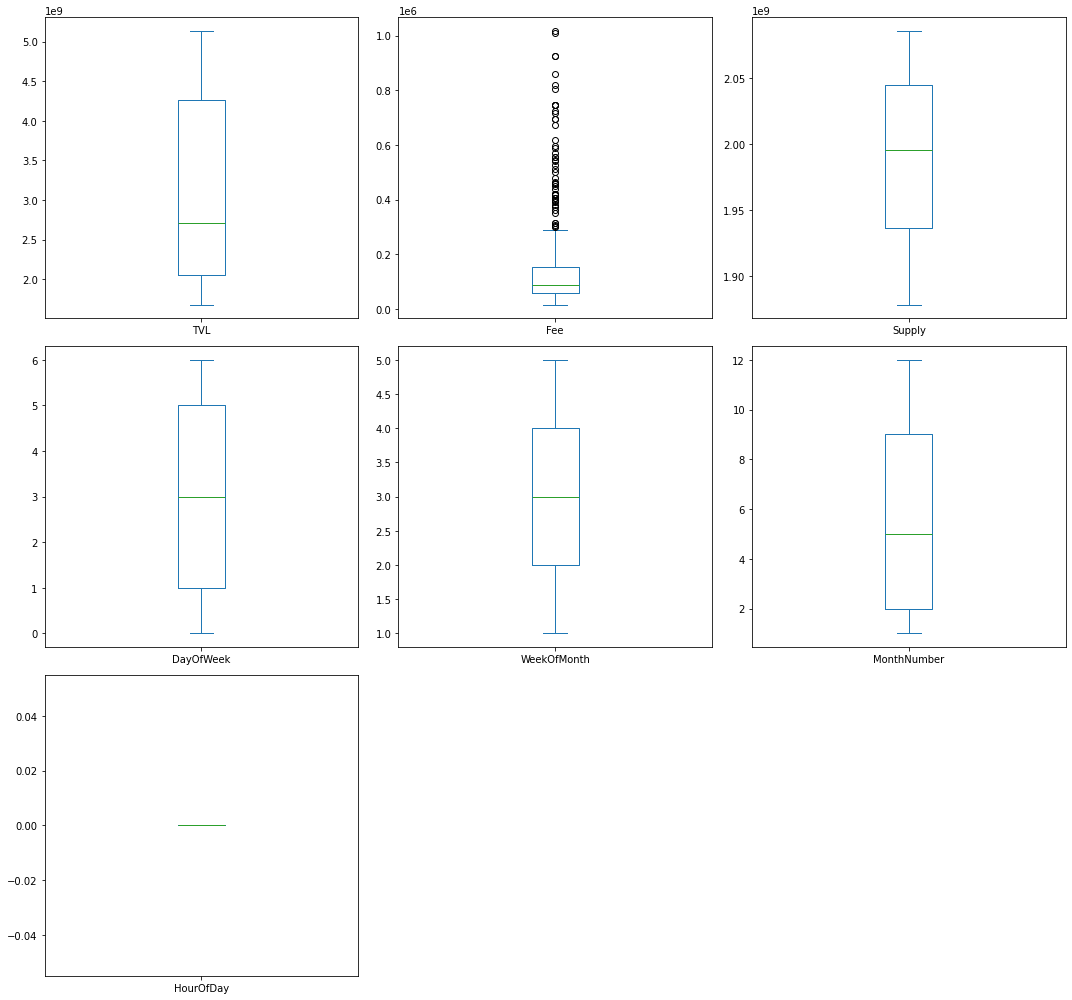

Original DataFrame shape: (446, 8)
DataFrame after removing outliers shape: (420, 8)


In [534]:
# Outliers part
plot_column_boxplots(df_crv_cleaned)
df_crv_cleaned = handle_outliers_mask(df_crv_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


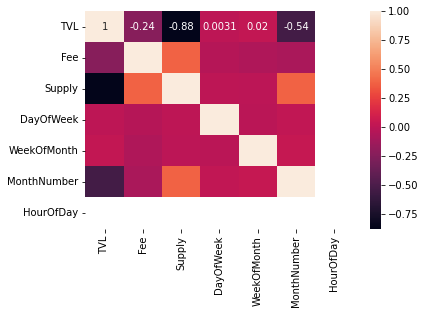

In [535]:
# Checking collinearity
corr_crv = collinearity(df_crv_cleaned)

In [536]:
df_crv_cleaned

,date,TVL,Fee,Supply,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
1057,2023-01-01,3.600588e+09,27800.211683,1.878167e+09,6,1,1,0
1058,2023-01-02,3.605495e+09,33613.338931,1.878674e+09,0,1,1,0
1059,2023-01-03,3.632737e+09,55004.926433,1.879188e+09,1,1,1,0
1060,2023-01-04,3.640003e+09,76006.190360,1.879670e+09,2,1,1,0
1061,2023-01-05,3.663339e+09,81454.465742,1.880368e+09,3,1,1,0
...,...,...,...,...,...,...,...,...
1495,2024-03-14,2.856223e+09,450074.000000,2.085633e+09,3,2,3,0
1496,2024-03-15,2.795147e+09,696195.000000,2.085633e+09,4,3,3,0
1497,2024-03-16,2.715320e+09,819008.000000,2.085633e+09,5,3,3,0
1498,2024-03-17,2.597215e+09,457757.000000,2.085633e+09,6,3,3,0


# SNX (Yield, Staking, Unique Addresses Missing)

In [537]:
# TVL
df_snx_tvl = tvl_dfs.get('synthetix_tvl')
df_snx_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_snx_tvl['date'] = pd.to_datetime(df_snx_tvl['date']).dt.date

In [538]:
# Fee
df_snx_fee = fee_dfs.get('synthetix')

In [539]:
# Supply
df_snx_supply = dune_get('supply', 'times', 'cumsupplyusdComplete', 'https://api.dune.com/api/v1/query/285163/results?')

In [540]:
# User Growth
df_snx_userg = dune_get('user', 'date', 'total_users', 'https://api.dune.com/api/v1/query/40854/results?')

In [541]:
# Summerizing all to one dict for convenience
dict_snx = get_dict('snx', protocol_dict)
dict_snx = convert_date_columns(dict_snx)

DataFrame named df_snx_apy not found.
DataFrame named df_snx_staking not found.
DataFrame named df_snx_address not found.
DataFrame named df_snx_trades not found.


In [542]:
# Combining
df_snx = combine(dict_snx)
df_snx = df_snx[df_snx['date'] > cutoff_date]
df_snx

,date,TVL,Fee,Supply,User Growth
1435,2023-01-01,2.463596e+08,1491.490045,NaN,NaN
1436,2023-01-02,2.509005e+08,15059.917257,8.972240e+05,10409.0
1437,2023-01-02,2.509005e+08,15059.917257,8.381776e+06,10409.0
1438,2023-01-02,2.509005e+08,15059.917257,6.072970e+04,10409.0
1439,2023-01-02,2.509005e+08,15059.917257,5.070950e+07,10409.0
...,...,...,...,...,...
1957,2023-05-26,NaN,60855.905875,NaN,NaN
1958,2023-05-27,NaN,42374.315156,NaN,NaN
1959,2023-05-28,NaN,112067.350851,NaN,NaN
1960,2024-01-04,NaN,66301.618164,NaN,NaN


In [543]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_snx)
add_ts_columns(df_snx)
checking_nas(df_snx)

DataFrame Shape: (509, 5)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 509 entries, 1435 to 1961
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         509 non-null    object 
 1   TVL          500 non-null    float64
 2   Fee          508 non-null    float64
 3   Supply       80 non-null     float64
 4   User Growth  77 non-null     float64
dtypes: float64(4), object(1)
memory usage: 23.9+ KB
None
Missing values over 10%: date           False
TVL            False
Fee            False
Supply          True
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Fee             True
Supply         False
User Growth    False
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: bool
Missing values over 0%: date           False
T

In [544]:
# Cleaning process, na and duplicates part
df_snx_cleaned = handle_nas(df_snx)
df_snx_cleaned = handle_duplicates(df_snx_cleaned)

Duplicates:  1435    False
1436    False
1437     True
1438     True
1439     True
        ...  
1957    False
1958    False
1959    False
1960    False
1961    False
Length: 509, dtype: bool


In [545]:
# Final check for any missing values
print("Final check for missing values:")
print(df_snx_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


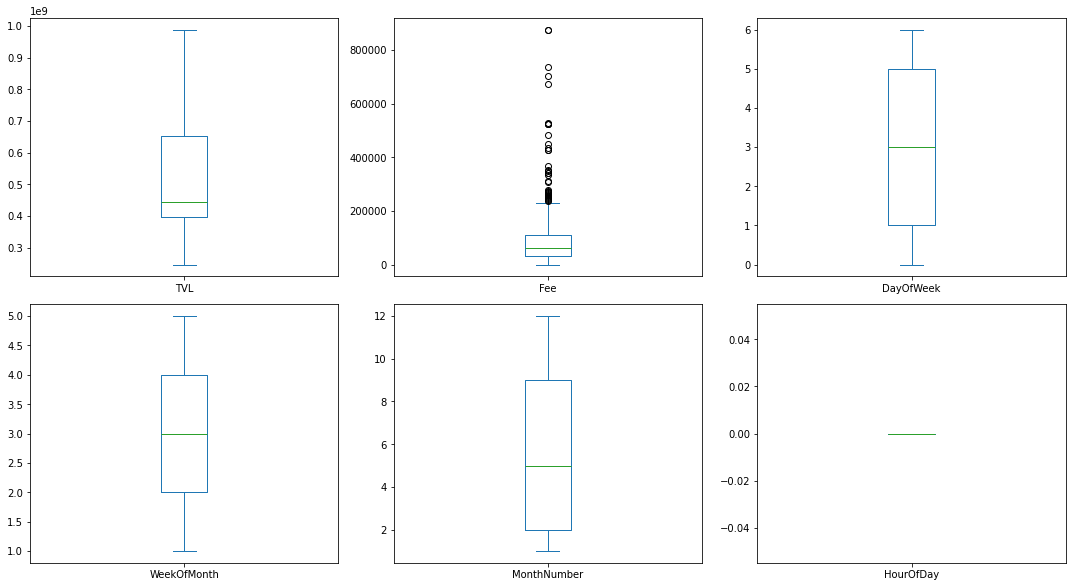

Original DataFrame shape: (445, 7)
DataFrame after removing outliers shape: (430, 7)


In [546]:
# Outliers part
plot_column_boxplots(df_snx_cleaned)
df_snx_cleaned = handle_outliers_mask(df_snx_cleaned)

/Users/zhaoyuchen/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


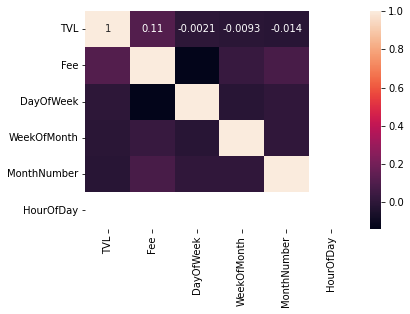

In [547]:
# Checking collinearity
corr_snx = collinearity(df_snx_cleaned)

In [548]:
df_snx_cleaned

,date,TVL,Fee,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
1445,2023-01-07,2.780308e+08,2443.904909,5,1,1,0
1446,2023-01-08,2.795471e+08,17084.296111,6,2,1,0
1447,2023-01-09,2.911934e+08,21302.121235,0,2,1,0
1452,2023-01-10,3.010150e+08,13586.405747,1,2,1,0
1453,2023-01-11,2.995604e+08,12037.354934,2,2,1,0
...,...,...,...,...,...,...,...
1957,2023-05-26,7.299400e+08,60855.905875,4,4,5,0
1958,2023-05-27,7.299400e+08,42374.315156,5,4,5,0
1959,2023-05-28,7.299400e+08,112067.350851,6,4,5,0
1960,2024-01-04,7.299400e+08,66301.618164,3,1,1,0


In [549]:
df_snx_cleaned.to_csv('output1.csv', index=False)

# Lido (Unique Address, User Growth Missing)

In [550]:
# Supply
df_lido_supply = dune_get('supply', 'time', 'total_supply', 'https://api.dune.com/api/v1/query/2465917/results?')

In [551]:
# Daily Trade volume
df_lido_trades = dune_get('trade volume', 'day', 'volume', 'https://api.dune.com/api/v1/query/2855413/results?')

In [552]:
# TVL
df_lido_tvl = tvl_dfs.get('Lido_tvl')
df_lido_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_lido_tvl['date'] = pd.to_datetime(df_lido_tvl['date']).dt.date

In [553]:
# Fee
df_lido_fee = fee_dfs.get('Lido')

In [554]:
# Yield
df_lido_apy = yield_dfs.get('lido')

In [555]:
# Summerizing all to one dict for convenience
dict_lido = get_dict('lido', protocol_dict)
dict_lido = convert_date_columns(dict_lido)

DataFrame named df_lido_staking not found.
DataFrame named df_lido_address not found.
DataFrame named df_lido_userg not found.


In [556]:
# Combining
df_lido = combine(dict_lido)

df_lido = df_lido[df_lido['date'] > cutoff_date]
df_lido

,date,TVL,Fee,APY,Supply,Trade Volume
742,2023-01-01,5.865784e+09,7.580771e+05,6.30,NaN,NaN
743,2023-01-02,5.877675e+09,7.958346e+05,6.30,1.000000e+09,NaN
744,2023-01-03,5.978871e+09,8.282336e+05,6.30,NaN,NaN
745,2023-01-04,5.971446e+09,9.001406e+05,6.30,NaN,NaN
746,2023-01-05,6.177010e+09,1.024031e+06,6.30,NaN,NaN
...,...,...,...,...,...,...
1732,2024-03-19,3.458437e+10,3.817791e+06,4.26,NaN,2.858150e+06
1733,2024-03-19,3.458437e+10,3.817791e+06,4.26,NaN,1.185349e+07
1734,2024-03-19,3.458437e+10,3.817791e+06,4.26,NaN,2.915744e+07
1735,2024-03-19,3.458437e+10,3.817791e+06,4.26,NaN,5.351035e+07


In [557]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_lido)
add_ts_columns(df_lido)
checking_nas(df_lido)

DataFrame Shape: (995, 6)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 742 to 1736
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          995 non-null    object 
 1   TVL           995 non-null    float64
 2   Fee           994 non-null    float64
 3   APY           995 non-null    float64
 4   Supply        126 non-null    float64
 5   Trade Volume  660 non-null    float64
dtypes: float64(5), object(1)
memory usage: 54.4+ KB
None
Missing values over 10%: date            False
TVL             False
Fee             False
APY             False
Supply           True
Trade Volume     True
DayOfWeek       False
WeekOfMonth     False
MonthNumber     False
HourOfDay       False
dtype: bool
Missing values under 10%: date             True
TVL              True
Fee              True
APY              True
Supply          False
Trade Volume    False
DayOfWeek        True
WeekOfMonth  

In [558]:
# Cleaning process, na and duplicates part
df_lido_cleaned = handle_nas(df_lido)
df_lido_cleaned = handle_duplicates(df_lido_cleaned)

Duplicates:  742     False
743     False
744     False
745     False
746     False
        ...  
1732    False
1733    False
1734    False
1735    False
1736    False
Length: 995, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'


In [559]:
# Final check for any missing values
print("Final check for missing values:")
print(df_lido_cleaned.isnull().sum())

Final check for missing values:
date            0
TVL             0
Fee             0
APY             0
Trade Volume    0
DayOfWeek       0
WeekOfMonth     0
MonthNumber     0
HourOfDay       0
dtype: int64


In [560]:
df_lido_cleaned

,date,TVL,Fee,APY,Trade Volume,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
742,2023-01-01,5.865784e+09,7.580771e+05,6.30,0,6,1,1,0
743,2023-01-02,5.877675e+09,7.958346e+05,6.30,0,0,1,1,0
744,2023-01-03,5.978871e+09,8.282336e+05,6.30,0,1,1,1,0
745,2023-01-04,5.971446e+09,9.001406e+05,6.30,0,2,1,1,0
746,2023-01-05,6.177010e+09,1.024031e+06,6.30,0,3,1,1,0
...,...,...,...,...,...,...,...,...,...
1732,2024-03-19,3.458437e+10,3.817791e+06,4.26,2858150.256995,1,3,3,0
1733,2024-03-19,3.458437e+10,3.817791e+06,4.26,11853490.08968,1,3,3,0
1734,2024-03-19,3.458437e+10,3.817791e+06,4.26,29157439.847894,1,3,3,0
1735,2024-03-19,3.458437e+10,3.817791e+06,4.26,53510349.201614,1,3,3,0


In [561]:
df_lido_cleaned.to_csv('lido_cleaned.csv', index=False)

# MakerDAO (Yield not enough observations, Liquidity, Unique Address, User Growth, Trade Volume Missing)

In [562]:
# Supply
df_mkr_supply = dune_get('supply', 'day', 'supply', 'https://api.dune.com/api/v1/query/3233304/results?')

In [563]:
# TVL
df_mkr_tvl = tvl_dfs.get('MakerDAO_tvl')
df_mkr_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_mkr_tvl['date'] = pd.to_datetime(df_mkr_tvl['date']).dt.date

In [564]:
# Fee
df_mkr_fee = fee_dfs.get('MakerDAO')

In [565]:
# Yield
df_mkr_apy = yield_dfs.get('makerdao')

In [566]:
# Summerizing all to one dict for convenience
dict_mkr = get_dict('mkr', protocol_dict)
dict_mkr = convert_date_columns(dict_mkr)

DataFrame named df_mkr_staking not found.
DataFrame named df_mkr_address not found.
DataFrame named df_mkr_userg not found.
DataFrame named df_mkr_trades not found.


In [567]:
# Combining
df_mkr = combine(dict_mkr)
df_mkr = df_mkr[df_mkr['date'] > cutoff_date]

In [568]:
df_mkr

,date,TVL,Fee,APY,Supply
1458,2023-01-01,6.061066e+09,1.138267e+05,0.0,977631.036951
1459,2023-01-02,6.066049e+09,1.137154e+05,0.0,977631.036951
1460,2023-01-03,6.105567e+09,1.137815e+05,0.0,977631.036951
1461,2023-01-04,6.101488e+09,1.139230e+05,0.0,977631.036951
1462,2023-01-05,6.255951e+09,1.145138e+05,0.0,977631.036951
...,...,...,...,...,...
1898,2024-03-16,7.809578e+09,1.169733e+06,0.0,NaN
1899,2024-03-17,7.431851e+09,1.131247e+06,0.0,NaN
1900,2024-03-18,7.588995e+09,1.125001e+06,0.0,NaN
1901,2024-03-19,7.211185e+09,1.109749e+06,0.0,NaN


In [569]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_mkr)
add_ts_columns(df_mkr)
checking_nas(df_mkr)

DataFrame Shape: (445, 5)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 1458 to 1902
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    445 non-null    object 
 1   TVL     445 non-null    float64
 2   Fee     444 non-null    float64
 3   APY     427 non-null    float64
 4   Supply  422 non-null    float64
dtypes: float64(4), object(1)
memory usage: 20.9+ KB
None
Missing values over 10%: date           False
TVL            False
Fee            False
APY            False
Supply         False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date           True
TVL            True
Fee            True
APY            True
Supply         True
DayOfWeek      True
WeekOfMonth    True
MonthNumber    True
HourOfDay      True
dtype: bool
Missing values over 0%: date           False
TVL            False
Fee             True
APY

In [570]:
# Cleaning process, na and duplicates part
df_mkr_cleaned = handle_nas(df_mkr)
df_mkr_cleaned = handle_duplicates(df_mkr_cleaned)

Duplicates:  1458    False
1459    False
1460    False
1461    False
1462    False
        ...  
1898    False
1899    False
1900    False
1901    False
1902    False
Length: 445, dtype: bool


In [571]:
# Final check for any missing values
print("Final check for missing values:")
print(df_mkr_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
APY            0
Supply         0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [572]:
df_mkr_cleaned

,date,TVL,Fee,APY,Supply,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
1458,2023-01-01,6.061066e+09,1.138267e+05,0.0,977631.036951,6,1,1,0
1459,2023-01-02,6.066049e+09,1.137154e+05,0.0,977631.036951,0,1,1,0
1460,2023-01-03,6.105567e+09,1.137815e+05,0.0,977631.036951,1,1,1,0
1461,2023-01-04,6.101488e+09,1.139230e+05,0.0,977631.036951,2,1,1,0
1462,2023-01-05,6.255951e+09,1.145138e+05,0.0,977631.036951,3,1,1,0
...,...,...,...,...,...,...,...,...,...
1898,2024-03-16,7.809578e+09,1.169733e+06,0.0,977631.036951,5,3,3,0
1899,2024-03-17,7.431851e+09,1.131247e+06,0.0,977631.036951,6,3,3,0
1900,2024-03-18,7.588995e+09,1.125001e+06,0.0,977631.036951,0,3,3,0
1901,2024-03-19,7.211185e+09,1.109749e+06,0.0,977631.036951,1,3,3,0


# aave (Yield not enough observations, Unique Address, Trade Volume Missing)

In [573]:
# Supply
# df_aave_supply = dune_get('supply', 'time', 'Total_Supply', 'https://api.dune.com/api/v1/query/2652105/results?')

In [574]:
# User Growth
df_aave_userg = dune_get('user', 'date', 'active_depositors', 'https://api.dune.com/api/v1/query/2487715/results?')

In [575]:
# Liquidity (Staking Pool)
df_aave_staking = dune_get('staking', 'day', 'cumulative_staked', 'https://api.dune.com/api/v1/query/155127/results?')

In [576]:
# TVL
df_aave_tvl = tvl_dfs.get('aave_tvl')
df_aave_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_aave_tvl['date'] = pd.to_datetime(df_aave_tvl['date']).dt.date

In [577]:
# Fee
df_aave_fee = fee_dfs.get('aave')

In [578]:
# Yield
df_aave_apy = yield_dfs.get('aave-v3')

In [579]:
# Summerizing all to one dict for convenience
dict_aave = get_dict('aave', protocol_dict)
dict_aave = convert_date_columns(dict_aave)

DataFrame named df_aave_supply not found.
DataFrame named df_aave_address not found.
DataFrame named df_aave_trades not found.


In [580]:
# Combining
df_aave = combine(dict_aave)
df_aave = df_aave[df_aave['date'] > cutoff_date]

In [581]:
df_aave

,date,TVL,Fee,APY,Staking,User Growth
956,2023-01-01,3.683459e+09,143867.669986,0.35554,2.386657e+06,3772.0
957,2023-01-02,3.696521e+09,140850.398041,0.35555,2.386386e+06,NaN
958,2023-01-03,3.731498e+09,140330.556659,0.36113,2.396484e+06,NaN
959,2023-01-04,3.726974e+09,144336.799166,0.36129,2.396726e+06,NaN
960,2023-01-05,3.789374e+09,146052.620578,0.36158,2.407457e+06,NaN
...,...,...,...,...,...,...
1397,2024-03-17,1.084567e+10,299557.000000,22.22987,NaN,NaN
1398,2024-03-18,1.114182e+10,175487.000000,22.75164,NaN,NaN
1399,2024-03-19,1.093014e+10,262336.000000,21.77026,NaN,NaN
1400,2024-03-20,1.044143e+10,NaN,21.77026,NaN,NaN


In [582]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_aave)
add_ts_columns(df_aave)
checking_nas(df_aave)

DataFrame Shape: (446, 6)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 956 to 1401
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         446 non-null    object 
 1   TVL          446 non-null    float64
 2   Fee          444 non-null    float64
 3   APY          430 non-null    float64
 4   Staking      421 non-null    float64
 5   User Growth  12 non-null     float64
dtypes: float64(5), object(1)
memory usage: 24.4+ KB
None
Missing values over 10%: date           False
TVL            False
Fee            False
APY            False
Staking        False
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Fee             True
APY             True
Staking         True
User Growth    False
DayOfWeek       True
WeekOfMonth     True
MonthNumber     T

In [583]:
# Cleaning process, na and duplicates part
df_aave_cleaned = handle_nas(df_aave)
df_aave_cleaned = handle_duplicates(df_aave_cleaned)

Duplicates:  956     False
957     False
958     False
959     False
960     False
        ...  
1397    False
1398    False
1399    False
1400    False
1401    False
Length: 446, dtype: bool


In [584]:
# Final check for any missing values
print("Final check for missing values:")
print(df_aave_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
APY            0
Staking        0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [585]:
df_aave_cleaned

,date,TVL,Fee,APY,Staking,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
956,2023-01-01,3.683459e+09,143867.669986,0.35554,2.386657e+06,6,1,1,0
957,2023-01-02,3.696521e+09,140850.398041,0.35555,2.386386e+06,0,1,1,0
958,2023-01-03,3.731498e+09,140330.556659,0.36113,2.396484e+06,1,1,1,0
959,2023-01-04,3.726974e+09,144336.799166,0.36129,2.396726e+06,2,1,1,0
960,2023-01-05,3.789374e+09,146052.620578,0.36158,2.407457e+06,3,1,1,0
...,...,...,...,...,...,...,...,...,...
1397,2024-03-17,1.084567e+10,299557.000000,22.22987,2.709469e+06,6,3,3,0
1398,2024-03-18,1.114182e+10,175487.000000,22.75164,2.709469e+06,0,3,3,0
1399,2024-03-19,1.093014e+10,262336.000000,21.77026,2.709469e+06,1,3,3,0
1400,2024-03-20,1.044143e+10,262336.000000,21.77026,2.709469e+06,2,3,3,0


# JustLend (Fee, User Growth not enough observations; Yield, Supply, Unique Address, Liquidity, Trade Volume Missing)

In [586]:
# User Growth
df_justlend_userg = dune_get('user', 'day', 'dau', 'https://api.dune.com/api/v1/query/1218967/results?')

In [587]:
# TVL
df_justlend_tvl = tvl_dfs.get('JustLend_tvl')
df_justlend_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_justlend_tvl['date'] = pd.to_datetime(df_justlend_tvl['date']).dt.date

In [588]:
# Fee
df_justlend_fee = fee_dfs.get('JustLend')

In [589]:
# Summerizing all to one dict for convenience
dict_justlend = get_dict('justlend', protocol_dict)
dict_justlend = convert_date_columns(dict_justlend)

DataFrame named df_justlend_apy not found.
DataFrame named df_justlend_supply not found.
DataFrame named df_justlend_staking not found.
DataFrame named df_justlend_address not found.
DataFrame named df_justlend_trades not found.


In [590]:
# Combining
df_justlend = combine(dict_justlend)
df_justlend = df_justlend[df_justlend['date'] > cutoff_date]


In [591]:
df_justlend

,date,TVL,Fee,User Growth
426,2023-01-01,2.589654e+09,NaN,NaN
427,2023-01-02,2.588499e+09,NaN,NaN
428,2023-01-03,2.594248e+09,NaN,NaN
429,2023-01-04,2.576686e+09,NaN,NaN
430,2023-01-05,2.607046e+09,NaN,NaN
...,...,...,...,...
866,2024-03-16,7.704157e+09,9316.0,801.0
867,2024-03-17,7.259559e+09,9603.0,807.0
868,2024-03-18,7.614927e+09,9368.0,856.0
869,2024-03-19,7.454181e+09,9506.0,371.0


In [592]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_justlend)
add_ts_columns(df_justlend)
checking_nas(df_justlend)

DataFrame Shape: (445, 4)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 426 to 870
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         445 non-null    object 
 1   TVL          445 non-null    float64
 2   Fee          121 non-null    float64
 3   User Growth  31 non-null     float64
dtypes: float64(3), object(1)
memory usage: 17.4+ KB
None
Missing values over 10%: date           False
TVL            False
Fee             True
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Fee            False
User Growth    False
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: bool
Missing values over 0%: date           False
TVL            False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
Hou

In [593]:
# Cleaning process, na and duplicates part
df_justlend_cleaned = handle_nas(df_justlend)
df_justlend_cleaned = handle_duplicates(df_justlend_cleaned)

Duplicates:  426    False
427    False
428    False
429    False
430    False
       ...  
866    False
867    False
868    False
869    False
870    False
Length: 445, dtype: bool


In [594]:
# Final check for any missing values
print("Final check for missing values:")
print(df_justlend_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [595]:
df_justlend_cleaned

,date,TVL,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
426,2023-01-01,2.589654e+09,6,1,1,0
427,2023-01-02,2.588499e+09,0,1,1,0
428,2023-01-03,2.594248e+09,1,1,1,0
429,2023-01-04,2.576686e+09,2,1,1,0
430,2023-01-05,2.607046e+09,3,1,1,0
...,...,...,...,...,...,...
866,2024-03-16,7.704157e+09,5,3,3,0
867,2024-03-17,7.259559e+09,6,3,3,0
868,2024-03-18,7.614927e+09,0,3,3,0
869,2024-03-19,7.454181e+09,1,3,3,0


# uniswap (User Growth, Yield not enough observations; Supply, Unique Address, Liquidity, Trade Volume Missing)

In [596]:
# User Growth
df_uni_userg = dune_get('user', 'day', 'users', 'https://api.dune.com/api/v1/query/2315384/results?')

In [597]:
# Supply
# df_uni_supply = dune_get('supply', 'day', 'total_supply', 'https://api.dune.com/api/v1/query/3251900/results?')

In [598]:
# TVL
df_uni_tvl = tvl_dfs.get('uniswap_tvl')
df_uni_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_uni_tvl['date'] = pd.to_datetime(df_uni_tvl['date']).dt.date

In [599]:
# Fee
df_uni_fee = fee_dfs.get('uniswap')

In [600]:
# Yield
df_uni_apy = yield_dfs.get('uniswap-v2')

In [601]:
# Summerizing all to one dict for convenience
dict_uni = get_dict('uni', protocol_dict)
dict_uni = convert_date_columns(dict_uni)

DataFrame named df_uni_supply not found.
DataFrame named df_uni_staking not found.
DataFrame named df_uni_address not found.
DataFrame named df_uni_trades not found.


In [602]:
# Combining
df_uni = combine(dict_uni)
df_uni = df_uni[df_uni['date'] > cutoff_date]

In [603]:
df_uni

,date,TVL,Fee,APY,User Growth
1520,2023-01-01,3.265141e+09,46.081696,0.0,NaN
1521,2023-01-02,3.281286e+09,8.282451,0.0,NaN
1522,2023-01-03,3.299442e+09,13.598657,0.0,NaN
1523,2023-01-04,3.328336e+09,68.774396,0.0,NaN
1524,2023-01-05,3.372590e+09,10.537179,0.0,NaN
...,...,...,...,...,...
2591,2024-03-17,5.573709e+09,0.000000,0.0,NaN
2592,2024-03-18,5.732130e+09,0.000000,0.0,NaN
2593,2024-03-19,5.569406e+09,0.000000,0.0,NaN
2594,2024-03-20,5.286432e+09,NaN,0.0,NaN


In [604]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_uni)
add_ts_columns(df_uni)
checking_nas(df_uni)

DataFrame Shape: (1076, 5)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 1076 entries, 1520 to 2595
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1076 non-null   object 
 1   TVL          1076 non-null   float64
 2   Fee          1074 non-null   float64
 3   APY          813 non-null    float64
 4   User Growth  720 non-null    float64
dtypes: float64(4), object(1)
memory usage: 50.4+ KB
None
Missing values over 10%: date           False
TVL            False
Fee            False
APY             True
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Fee             True
APY            False
User Growth    False
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: bool
Missing values over 0%: date           False

In [605]:
# Cleaning process, na and duplicates part
df_uni_cleaned = handle_nas(df_uni)
df_uni_cleaned = handle_duplicates(df_uni_cleaned)

Duplicates:  1520    False
1521    False
1522    False
1523    False
1524    False
        ...  
2591    False
2592    False
2593    False
2594    False
2595    False
Length: 1076, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'


In [606]:
# Final check for any missing values
print("Final check for missing values:")
print(df_uni_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
APY            0
User Growth    0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [607]:
df_uni_cleaned

,date,TVL,Fee,APY,User Growth,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
1520,2023-01-01,3.265141e+09,46.081696,0.0,0,6,1,1,0
1521,2023-01-02,3.281286e+09,8.282451,0.0,0,0,1,1,0
1522,2023-01-03,3.299442e+09,13.598657,0.0,0,1,1,1,0
1523,2023-01-04,3.328336e+09,68.774396,0.0,0,2,1,1,0
1524,2023-01-05,3.372590e+09,10.537179,0.0,0,3,1,1,0
...,...,...,...,...,...,...,...,...,...
2591,2024-03-17,5.573709e+09,0.000000,0.0,412.0,6,3,3,0
2592,2024-03-18,5.732130e+09,0.000000,0.0,412.0,0,3,3,0
2593,2024-03-19,5.569406e+09,0.000000,0.0,412.0,1,3,3,0
2594,2024-03-20,5.286432e+09,0.000000,0.0,412.0,2,3,3,0


# pancakeswap (User Growth, Supply, Unique Address, Liquidity, Trade Volume Missing)

In [608]:
# Supply
# df_pcs_supply = dune_get('supply', 'day', 'total_supply', 'https://api.dune.com/api/v1/query/3166271/results?')

In [609]:
# User Growth
df_pcs_userg = dune_get('user', 'week', 'user', 'https://api.dune.com/api/v1/query/2203676/results?')

In [610]:
# TVL
df_pcs_tvl = tvl_dfs.get('pancakeswap_tvl')
df_pcs_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_pcs_tvl['date'] = pd.to_datetime(df_pcs_tvl['date']).dt.date

In [611]:
# Fee
df_pcs_fee = fee_dfs.get('pancakeswap')

In [612]:
# Yield
df_pcs_apy = yield_dfs.get('pancakeswap-amm')

In [613]:
# Summerizing all to one dict for convenience
dict_pcs = get_dict('pcs', protocol_dict)
#dict_pcs = convert_date_columns(dict_pcs)

DataFrame named df_pcs_supply not found.
DataFrame named df_pcs_staking not found.
DataFrame named df_pcs_address not found.
DataFrame named df_pcs_trades not found.


In [614]:
# Combining
df_pcs = combine(dict_pcs)
df_pcs = df_pcs[df_pcs['date'] > cutoff_date]

In [615]:
df_pcs

,date,TVL,APY,User Growth
619,2023-01-01,2.390841e+09,3.62,NaN
620,2023-01-02,2.379485e+09,3.62,NaN
621,2023-01-03,2.392568e+09,4.07,NaN
622,2023-01-04,2.389330e+09,3.47,NaN
623,2023-01-05,2.459544e+09,3.20,NaN
...,...,...,...,...
1060,2024-03-17,2.260613e+09,17.19,NaN
1061,2024-03-18,2.266740e+09,16.12,NaN
1062,2024-03-19,2.233232e+09,15.45,NaN
1063,2024-03-20,2.145938e+09,15.91,NaN


In [616]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_pcs)
add_ts_columns(df_pcs)
checking_nas(df_pcs)

DataFrame Shape: (446, 4)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 619 to 1064
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         446 non-null    object 
 1   TVL          446 non-null    float64
 2   APY          446 non-null    float64
 3   User Growth  62 non-null     float64
dtypes: float64(3), object(1)
memory usage: 17.4+ KB
None
Missing values over 10%: date           False
TVL            False
APY            False
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
APY             True
User Growth    False
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: bool
Missing values over 0%: date           False
TVL            False
APY            False
DayOfWeek      False
WeekOfMonth    False
Mo

In [617]:
# Cleaning process, na and duplicates part
df_pcs_cleaned = handle_nas(df_pcs)
df_pcs_cleaned = handle_duplicates(df_pcs_cleaned)

Duplicates:  619     False
620     False
621     False
622     False
623     False
        ...  
1060    False
1061    False
1062    False
1063    False
1064    False
Length: 446, dtype: bool


In [618]:
# Final check for any missing values
print("Final check for missing values:")
print(df_pcs_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
APY            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [619]:
df_pcs_cleaned

,date,TVL,APY,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
619,2023-01-01,2.390841e+09,3.62,6,1,1,0
620,2023-01-02,2.379485e+09,3.62,0,1,1,0
621,2023-01-03,2.392568e+09,4.07,1,1,1,0
622,2023-01-04,2.389330e+09,3.47,2,1,1,0
623,2023-01-05,2.459544e+09,3.20,3,1,1,0
...,...,...,...,...,...,...,...
1060,2024-03-17,2.260613e+09,17.19,6,3,3,0
1061,2024-03-18,2.266740e+09,16.12,0,3,3,0
1062,2024-03-19,2.233232e+09,15.45,1,3,3,0
1063,2024-03-20,2.145938e+09,15.91,2,3,3,0


# Compound-finance  (Yield not enough observations;  User Growth, Supply, Unique Address, Liquidity, Trade Volume Missing)¶

In [620]:
# Supply
df_cpf_supply = dune_get('supply', 'period', 'supply', 'https://api.dune.com/api/v1/query/3242994/results?')

In [621]:
# TVL
df_cpf_tvl = tvl_dfs.get('compound-finance_tvl')
df_cpf_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_cpf_tvl['date'] = pd.to_datetime(df_cpf_tvl['date']).dt.date

In [622]:
# Fee
df_cpf_fee = fee_dfs.get('compound-finance')

In [623]:
# Yield
df_cpf_apy = yield_dfs.get('compound-v3')

In [624]:
# Summerizing all to one dict for convenience
dict_cpf = get_dict('cpf', protocol_dict)
dict_cpf = convert_date_columns(dict_cpf)

DataFrame named df_cpf_staking not found.
DataFrame named df_cpf_address not found.
DataFrame named df_cpf_userg not found.
DataFrame named df_cpf_trades not found.


In [625]:
# Combining
df_cpf = combine(dict_cpf)
df_cpf = df_cpf[df_cpf['date'] > cutoff_date]

In [626]:
df_cpf

,date,TVL,Fee,APY,Supply
1903,2023-01-01,1.635345e+09,45444.744218,NaN,5.480156e+08
1904,2023-01-02,1.631661e+09,43636.775080,NaN,5.520935e+08
1905,2023-01-03,1.639495e+09,43577.728897,NaN,5.579858e+08
1906,2023-01-04,1.640872e+09,45181.988365,NaN,5.576412e+08
1907,2023-01-05,1.670808e+09,43511.710983,NaN,5.520864e+08
...,...,...,...,...,...
2344,2024-03-17,2.680833e+09,129433.000000,0.0,NaN
2345,2024-03-18,2.775982e+09,102713.000000,0.0,NaN
2346,2024-03-19,2.758266e+09,73792.000000,0.0,NaN
2347,2024-03-20,2.619498e+09,NaN,0.0,NaN


In [627]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_cpf)
add_ts_columns(df_cpf)
checking_nas(df_cpf)

DataFrame Shape: (446, 5)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 1903 to 2348
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    446 non-null    object 
 1   TVL     446 non-null    float64
 2   Fee     444 non-null    float64
 3   APY     420 non-null    float64
 4   Supply  424 non-null    float64
dtypes: float64(4), object(1)
memory usage: 20.9+ KB
None
Missing values over 10%: date           False
TVL            False
Fee            False
APY            False
Supply         False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date           True
TVL            True
Fee            True
APY            True
Supply         True
DayOfWeek      True
WeekOfMonth    True
MonthNumber    True
HourOfDay      True
dtype: bool
Missing values over 0%: date           False
TVL            False
Fee             True
APY

In [628]:
# Cleaning process, na and duplicates part
df_cpf_cleaned = handle_nas(df_cpf)
df_cpf_cleaned = handle_duplicates(df_cpf_cleaned)

Duplicates:  1903    False
1904    False
1905    False
1906    False
1907    False
        ...  
2344    False
2345    False
2346    False
2347    False
2348    False
Length: 446, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'


In [629]:
# Final check for any missing values
print("Final check for missing values:")
print(df_cpf_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
APY            0
Supply         0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [630]:
df_cpf_cleaned

,date,TVL,Fee,APY,Supply,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
1903,2023-01-01,1.635345e+09,45444.744218,0,5.480156e+08,6,1,1,0
1904,2023-01-02,1.631661e+09,43636.775080,0,5.520935e+08,0,1,1,0
1905,2023-01-03,1.639495e+09,43577.728897,0,5.579858e+08,1,1,1,0
1906,2023-01-04,1.640872e+09,45181.988365,0,5.576412e+08,2,1,1,0
1907,2023-01-05,1.670808e+09,43511.710983,0,5.520864e+08,3,1,1,0
...,...,...,...,...,...,...,...,...,...
2344,2024-03-17,2.680833e+09,129433.000000,0.0,1.293669e+08,6,3,3,0
2345,2024-03-18,2.775982e+09,102713.000000,0.0,1.293669e+08,0,3,3,0
2346,2024-03-19,2.758266e+09,73792.000000,0.0,1.293669e+08,1,3,3,0
2347,2024-03-20,2.619498e+09,73792.000000,0.0,1.293669e+08,2,3,3,0


# venus (Fee, Liquidity, supply not enough observations;  User Growth, Unique Address, Trade Volume Missing)¶

In [631]:
# User Growth
df_ven_userg = dune_get('user', 'dt', 'num_users', 'https://api.dune.com/api/v1/query/2303280/results?')

In [632]:
# Supply
df_ven_supply = dune_get('supply', 'dt', 'Net_Supply', 'https://api.dune.com/api/v1/query/2303280/results?')

In [633]:
# Liquidity (Staking Pool)
df_ven_staking = dune_get('staking', 'dt', 'xvs_staked_amount', 'https://api.dune.com/api/v1/query/3147490/results?')

In [634]:
# TVL
df_ven_tvl = tvl_dfs.get('venus_tvl')
df_ven_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_ven_tvl['date'] = pd.to_datetime(df_ven_tvl['date']).dt.date

In [635]:
# Fee
df_ven_fee = fee_dfs.get('venus')

In [636]:
# Yield
df_ven_apy = yield_dfs.get('venus-core-pool')

In [637]:
# Summerizing all to one dict for convenience
dict_ven = get_dict('ven', protocol_dict)
dict_ven = convert_date_columns(dict_ven)

DataFrame named df_ven_address not found.
DataFrame named df_ven_trades not found.


In [638]:
# Combining
df_ven = combine(dict_ven)
df_ven = df_ven[df_ven['date'] > cutoff_date]

In [639]:
df_ven

,date,TVL,Fee,APY,Supply,Staking,User Growth
911,2023-01-01,6.510526e+08,NaN,NaN,NaN,NaN,NaN
912,2023-01-02,6.536721e+08,NaN,NaN,NaN,NaN,NaN
913,2023-01-03,6.580823e+08,NaN,NaN,NaN,1025.820532,NaN
914,2023-01-03,6.580823e+08,NaN,NaN,NaN,2259.154046,NaN
915,2023-01-03,6.580823e+08,NaN,NaN,NaN,2324.036977,NaN
...,...,...,...,...,...,...,...
1469,2024-03-17,1.598662e+09,1050184.0,20.64706,NaN,NaN,NaN
1470,2024-03-18,1.683666e+09,398208.0,18.51151,-3.861602e+08,NaN,2375.0
1471,2024-03-19,1.695967e+09,8135.0,15.69356,NaN,NaN,NaN
1472,2024-03-20,1.593909e+09,NaN,37.93849,NaN,NaN,NaN


In [640]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_ven)
add_ts_columns(df_ven)
checking_nas(df_ven)

DataFrame Shape: (563, 7)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, 911 to 1473
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         563 non-null    object 
 1   TVL          563 non-null    float64
 2   Fee          264 non-null    float64
 3   APY          314 non-null    float64
 4   Supply       12 non-null     float64
 5   Staking      204 non-null    float64
 6   User Growth  12 non-null     float64
dtypes: float64(6), object(1)
memory usage: 35.2+ KB
None
Missing values over 10%: date           False
TVL            False
Fee             True
APY             True
Supply          True
Staking         True
User Growth     True
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Fee            False
APY            False
Supply         False
Staking        Fa

In [641]:
# Cleaning process, na and duplicates part
df_ven_cleaned = handle_nas(df_ven)
df_ven_cleaned = handle_duplicates(df_ven_cleaned)

Duplicates:  911     False
912     False
913     False
914      True
915      True
        ...  
1469    False
1470    False
1471    False
1472    False
1473    False
Length: 563, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/fo

In [642]:
# Final check for any missing values
print("Final check for missing values:")
print(df_ven_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
APY            0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [643]:
df_ven_cleaned

,date,TVL,Fee,APY,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
911,2023-01-01,6.510526e+08,0,0,6,1,1,0
912,2023-01-02,6.536721e+08,0,0,0,1,1,0
913,2023-01-03,6.580823e+08,0,0,1,1,1,0
917,2023-01-04,6.598080e+08,0,0,2,1,1,0
918,2023-01-05,6.831007e+08,0,0,3,1,1,0
...,...,...,...,...,...,...,...,...
1469,2024-03-17,1.598662e+09,1050184.0,20.64706,6,3,3,0
1470,2024-03-18,1.683666e+09,398208.0,18.51151,0,3,3,0
1471,2024-03-19,1.695967e+09,8135.0,15.69356,1,3,3,0
1472,2024-03-20,1.593909e+09,8135.0,37.93849,2,3,3,0


# pendle (Fee, User Growth, supply, Yield, Unique Address not enough observations; Trade Volume Missing)¶

In [644]:
# User Growth
df_pen_userg = dune_get('user', 'month', 'active_addresses', 'https://api.dune.com/api/v1/query/3326881/results?')

In [645]:
# Supply
df_pen_supply = dune_get('supply', 'day', 'MaxSupply', 'https://api.dune.com/api/v1/query/2953788/results?')

In [646]:
# Liquidity (Staking Pool)
df_pen_staking = dune_get('staking', 'day', 'staking', 'https://api.dune.com/api/v1/query/2964564/results?')

In [647]:
# Unique Addresses
df_pen_address = dune_get('addr', 'week', 'active_addresses', 'https://api.dune.com/api/v1/query/2923902/results?')

In [648]:
# TVL
df_pen_tvl = tvl_dfs.get('pendle_tvl')
df_pen_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_pen_tvl['date'] = pd.to_datetime(df_pen_tvl['date']).dt.date

In [649]:
# Fee
df_pen_fee = fee_dfs.get('pendle')

In [650]:
# Yield
df_pen_apy = yield_dfs.get('pendle')

In [651]:
# Summerizing all to one dict for convenience
dict_pen = get_dict('pen', protocol_dict)
dict_pen = convert_date_columns(dict_pen)

DataFrame named df_pen_trades not found.


In [652]:
# Combining
df_pen = combine(dict_pen)
df_pen = df_pen[df_pen['date'] > cutoff_date]

In [653]:
df_pen

,date,TVL,Fee,APY,Supply,Staking,Unique Addresses,User Growth
539,2023-01-01,1.543120e+07,NaN,NaN,NaN,NaN,NaN,NaN
540,2023-01-02,1.557004e+07,NaN,NaN,NaN,1.322052e+03,NaN,NaN
541,2023-01-03,1.567096e+07,NaN,NaN,NaN,NaN,NaN,NaN
542,2023-01-04,1.611524e+07,NaN,NaN,NaN,5.085083e+06,NaN,NaN
543,2023-01-05,1.588819e+07,NaN,NaN,NaN,4.301889e+05,NaN,NaN
...,...,...,...,...,...,...,...,...
1075,2024-03-16,2.432561e+09,27176.0,1.36329,NaN,NaN,NaN,NaN
1076,2024-03-17,2.311829e+09,41949.0,1.36329,NaN,NaN,NaN,NaN
1077,2024-03-18,2.356224e+09,32907.0,1.36329,NaN,NaN,NaN,NaN
1078,2024-03-19,2.345013e+09,27272.0,1.36329,NaN,NaN,NaN,NaN


In [654]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_pen)
add_ts_columns(df_pen)
checking_nas(df_pen)

DataFrame Shape: (541, 8)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 541 entries, 539 to 1079
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              541 non-null    object 
 1   TVL               541 non-null    float64
 2   Fee               324 non-null    float64
 3   APY               287 non-null    float64
 4   Supply            6 non-null      float64
 5   Staking           529 non-null    float64
 6   Unique Addresses  139 non-null    float64
 7   User Growth       28 non-null     float64
dtypes: float64(7), object(1)
memory usage: 38.0+ KB
None
Missing values over 10%: date                False
TVL                 False
Fee                  True
APY                  True
Supply               True
Staking             False
Unique Addresses     True
User Growth          True
DayOfWeek           False
WeekOfMonth         False
MonthNumber         False
HourOfDay    

In [655]:
# Cleaning process, na and duplicates part
df_pen_cleaned = handle_nas(df_pen)
df_pen_cleaned = handle_duplicates(df_pen_cleaned)

Duplicates:  539     False
540     False
541     False
542     False
543     False
        ...  
1075    False
1076    False
1077    False
1078    False
1079    False
Length: 541, dtype: bool


/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[column].iloc[0] = '0'
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/43883288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].iloc[0] = '0'
/var/fo

In [656]:
# Final check for any missing values
print("Final check for missing values:")
print(df_pen_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
Fee            0
APY            0
Staking        0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [657]:
df_pen_cleaned

,date,TVL,Fee,APY,Staking,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
539,2023-01-01,1.543120e+07,0,0,0,6,1,1,0
540,2023-01-02,1.557004e+07,0,0,1322.052278,0,1,1,0
541,2023-01-03,1.567096e+07,0,0,1322.052278,1,1,1,0
542,2023-01-04,1.611524e+07,0,0,5085082.510285,2,1,1,0
543,2023-01-05,1.588819e+07,0,0,430188.933075,3,1,1,0
...,...,...,...,...,...,...,...,...,...
1075,2024-03-16,2.432561e+09,27176.0,1.36329,1743.655665,5,3,3,0
1076,2024-03-17,2.311829e+09,41949.0,1.36329,1743.655665,6,3,3,0
1077,2024-03-18,2.356224e+09,32907.0,1.36329,1743.655665,0,3,3,0
1078,2024-03-19,2.345013e+09,27272.0,1.36329,1743.655665,1,3,3,0


# morpho (Fee not enough observations; User Growth, Unique Address, Trade Volume Missing)

In [658]:
# Supply
df_mor_supply = dune_get('supply', 'day', 'morpho_supply', 'https://api.dune.com/api/v1/query/3448076/results?')

In [659]:
# TVL
df_mor_tvl = tvl_dfs.get('morpho_tvl')
df_mor_tvl.rename(columns = {'totalLiquidityUSD': 'TVL'}, inplace = True)
df_mor_tvl['date'] = pd.to_datetime(df_mor_tvl['date']).dt.date

In [660]:
# Fee
df_mor_fee = fee_dfs.get('morpho')

In [661]:
# Yield
df_mor_apy = yield_dfs.get('morpho-aave')

In [662]:
# Summerizing all to one dict for convenience
dict_mor = get_dict('mor', protocol_dict)
dict_mor = convert_date_columns(dict_mor)

DataFrame named df_mor_staking not found.
DataFrame named df_mor_address not found.
DataFrame named df_mor_userg not found.
DataFrame named df_mor_trades not found.


In [663]:
# Combining
df_mor = combine(dict_mor)
df_mor = df_mor[df_mor['date'] > cutoff_date]

In [664]:
df_mor

,date,TVL,Fee,APY,Supply
135,2023-01-01,1.832979e+08,NaN,4.15531,3.887276e+08
136,2023-01-02,1.840785e+08,NaN,4.16355,3.936974e+08
137,2023-01-03,1.869461e+08,NaN,4.45624,3.914060e+08
138,2023-01-04,1.834439e+08,NaN,4.45520,3.969342e+08
139,2023-01-05,1.881023e+08,NaN,4.45539,3.980583e+08
...,...,...,...,...,...
576,2024-03-17,1.049464e+09,NaN,10.76986,1.293517e+09
577,2024-03-18,1.080222e+09,NaN,10.76985,NaN
578,2024-03-19,1.048329e+09,NaN,10.76984,NaN
579,2024-03-20,9.867762e+08,NaN,10.76984,NaN


In [665]:
# Checking process
# pre checking, adding time series columns, and checking nas
pre_checking(df_mor)
add_ts_columns(df_mor)
checking_nas(df_mor)

DataFrame Shape: (446, 5)
DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 135 to 580
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    446 non-null    object 
 1   TVL     446 non-null    float64
 2   Fee     142 non-null    float64
 3   APY     446 non-null    float64
 4   Supply  442 non-null    float64
dtypes: float64(4), object(1)
memory usage: 20.9+ KB
None
Missing values over 10%: date           False
TVL            False
Fee             True
APY            False
Supply         False
DayOfWeek      False
WeekOfMonth    False
MonthNumber    False
HourOfDay      False
dtype: bool
Missing values under 10%: date            True
TVL             True
Fee            False
APY             True
Supply          True
DayOfWeek       True
WeekOfMonth     True
MonthNumber     True
HourOfDay       True
dtype: bool
Missing values over 0%: date           False
TVL            False
APY            Fa

In [666]:
# Cleaning process, na and duplicates part
df_mor_cleaned = handle_nas(df_mor)
df_mor_cleaned = handle_duplicates(df_mor_cleaned)

Duplicates:  135    False
136    False
137    False
138    False
139    False
       ...  
576    False
577    False
578    False
579    False
580    False
Length: 446, dtype: bool


In [667]:
# Final check for any missing values
print("Final check for missing values:")
print(df_mor_cleaned.isnull().sum())

Final check for missing values:
date           0
TVL            0
APY            0
Supply         0
DayOfWeek      0
WeekOfMonth    0
MonthNumber    0
HourOfDay      0
dtype: int64


In [668]:
df_mor_cleaned

,date,TVL,APY,Supply,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay
135,2023-01-01,1.832979e+08,4.15531,3.887276e+08,6,1,1,0
136,2023-01-02,1.840785e+08,4.16355,3.936974e+08,0,1,1,0
137,2023-01-03,1.869461e+08,4.45624,3.914060e+08,1,1,1,0
138,2023-01-04,1.834439e+08,4.45520,3.969342e+08,2,1,1,0
139,2023-01-05,1.881023e+08,4.45539,3.980583e+08,3,1,1,0
...,...,...,...,...,...,...,...,...
576,2024-03-17,1.049464e+09,10.76986,1.293517e+09,6,3,3,0
577,2024-03-18,1.080222e+09,10.76985,1.293517e+09,0,3,3,0
578,2024-03-19,1.048329e+09,10.76984,1.293517e+09,1,3,3,0
579,2024-03-20,9.867762e+08,10.76984,1.293517e+09,2,3,3,0


In [671]:
dfs = [df_lido_cleaned,df_mkr_cleaned, df_aave_cleaned, df_justlend_cleaned, df_uni_cleaned, df_pcs_cleaned, df_cpf_cleaned, df_ven_cleaned,df_pen_cleaned, df_mor_cleaned,df_snx_cleaned, df_crv_cleaned, df_cvx_cleaned,  df_frx_cleaned, df_gmx_cleaned, df_poly_cleaned, df_dpx_cleaned, df_rdt_cleaned,  df_rbn_cleaned, df_looks_cleaned, df_bifi_cleaned, df_gns_cleaned, df_umami_cleaned, df_dydx_cleaned]
dfs_dict = {0:"lido", 1:"mkr", 2:"aave", 3:"justlend", 4:"uni" ,5:"pcs", 6:"cpf", 7:"ven", 8:"pen",9:"mor", 10:"snx",11:"crv",12:"cvx",13:"frx",14:"gmx",15:"poly", 16:"dpx",17:"rdt",18:"rbn",19:"looks",20:"bifi",21:"gns",22:"umami",23:'dydx'}
dfs_c = dfs.copy() 
for i, df in enumerate(dfs_c):
    # Look up the protocol name using the current index i
    protocol_name = dfs_dict[i]
    
    # Add a new column to the dataframe with the protocol name
    df['protocol name'] = protocol_name
    cols = df.columns.tolist()
    cols = ['protocol name'] + [col for col in cols if col != 'protocol name']
    df = df[cols]
dfs_c

/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/3589552718.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['protocol name'] = protocol_name
/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/3589552718.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['protocol name'] = protocol_name


[            date           TVL           Fee   APY     Trade Volume  \
 742   2023-01-01  5.865784e+09  7.580771e+05  6.30                0   
 743   2023-01-02  5.877675e+09  7.958346e+05  6.30                0   
 744   2023-01-03  5.978871e+09  8.282336e+05  6.30                0   
 745   2023-01-04  5.971446e+09  9.001406e+05  6.30                0   
 746   2023-01-05  6.177010e+09  1.024031e+06  6.30                0   
 ...          ...           ...           ...   ...              ...   
 1732  2024-03-19  3.458437e+10  3.817791e+06  4.26   2858150.256995   
 1733  2024-03-19  3.458437e+10  3.817791e+06  4.26   11853490.08968   
 1734  2024-03-19  3.458437e+10  3.817791e+06  4.26  29157439.847894   
 1735  2024-03-19  3.458437e+10  3.817791e+06  4.26  53510349.201614   
 1736  2024-03-20  3.104226e+10  3.817791e+06  4.26  53510349.201614   
 
       DayOfWeek  WeekOfMonth  MonthNumber  HourOfDay protocol name  
 742           6            1            1          0          l

In [679]:
combined_df = pd.concat(dfs_c, ignore_index=True, sort=False)
combined_cols = combined_df.columns.tolist()
combined_cols = ['protocol name'] + [combined_cols for combined_cols in combined_cols if combined_cols != 'protocol name']
combined_cols
combined_df = combined_df[combined_cols]
combined_df

,protocol name,date,TVL,Fee,APY,Trade Volume,DayOfWeek,WeekOfMonth,MonthNumber,HourOfDay,Supply,Staking,User Growth,GMX V1 APY,Unique Addresses
0,lido,2023-01-01,5.865784e+09,758077.06763,6.3,0,6,1,1,0,NaN,NaN,NaN,NaN,NaN
1,lido,2023-01-02,5.877675e+09,795834.632559,6.3,0,0,1,1,0,NaN,NaN,NaN,NaN,NaN
2,lido,2023-01-03,5.978871e+09,828233.608455,6.3,0,1,1,1,0,NaN,NaN,NaN,NaN,NaN
3,lido,2023-01-04,5.971446e+09,900140.594441,6.3,0,2,1,1,0,NaN,NaN,NaN,NaN,NaN
4,lido,2023-01-05,6.177010e+09,1024031.259103,6.3,0,3,1,1,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11466,dydx,2024-03-17,4.058563e+08,NaN,NaN,676222.648103,6,3,3,0,NaN,NaN,NaN,NaN,13.0
11467,dydx,2024-03-18,4.039711e+08,NaN,NaN,676222.648103,0,3,3,0,NaN,NaN,NaN,NaN,13.0
11468,dydx,2024-03-19,4.029669e+08,NaN,NaN,676222.648103,1,3,3,0,NaN,NaN,NaN,NaN,13.0
11469,dydx,2024-03-20,3.939918e+08,NaN,NaN,676222.648103,2,3,3,0,NaN,NaN,NaN,NaN,13.0


## Merging them into a complete dataframe structure

In [680]:
final_dfs = [df_lido_cleaned,df_mkr_cleaned, df_aave_cleaned, df_justlend_cleaned, df_uni_cleaned, df_pcs_cleaned, df_cpf_cleaned, df_ven_cleaned,df_pen_cleaned, df_mor_cleaned,df_snx_cleaned, df_crv_cleaned, df_cvx_cleaned,  df_frx_cleaned, df_gmx_cleaned, df_poly_cleaned, df_dpx_cleaned, df_rdt_cleaned,  df_rbn_cleaned, df_looks_cleaned, df_bifi_cleaned, df_gns_cleaned, df_umami_cleaned, df_dydx_cleaned]

dfs_dict = {0:"lido", 1:"mkr", 2:"aave", 3:"justlend", 4:"uni" ,5:"pcs", 6:"cpf", 7:"ven", 8:"pen",9:"mor", 10:"snx",11:"crv",12:"cvx",13:"frx",14:"gmx",15:"poly", 16:"dpx",17:"rdt",18:"rbn",19:"looks",20:"bifi",21:"gns",22:"umami",23:'dydx'}

for i, df in enumerate(final_dfs):
    df_name = dfs_dict[i]
    for col in df.columns:
        if col != "date":  # Check if the column is not "Date"
            df.rename(columns={col: f"{df_name}_{col}"}, inplace=True)

/var/folders/7m/38h6dz5s1fq07rpw6v3k2c5w0000gn/T/ipykernel_47999/2468676159.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={col: f"{df_name}_{col}"}, inplace=True)


In [681]:
df_start = final_dfs[0]

for df in final_dfs[1:]:
    df_start = pd.merge(df_start, df, on='date', how='inner') 

In [682]:
df_start.set_index('date', inplace=True)

In [683]:
#The reason why there are multiple entries for some dates is that some columns such as frx_unique address has so multiple data entries for one day.
df_start

,lido_TVL,lido_Fee,lido_APY,lido_Trade Volume,lido_DayOfWeek,lido_WeekOfMonth,lido_MonthNumber,lido_HourOfDay,lido_protocol name,mkr_TVL,...,umami_HourOfDay,umami_protocol name,dydx_TVL,dydx_Unique Addresses,dydx_Trade Volume,dydx_DayOfWeek,dydx_WeekOfMonth,dydx_MonthNumber,dydx_HourOfDay,dydx_protocol name
date,,,,,,,,,,,,,,,,,,,,,
2023-01-07,6.251892e+09,8.475202e+05,6.30,0,5,1,1,0,lido,6.245325e+09,...,0,umami,3.944870e+08,0,68117.584102,5,1,1,0,dydx
2023-01-08,6.216768e+09,8.005816e+05,6.30,0,6,2,1,0,lido,6.271289e+09,...,0,umami,3.958254e+08,0,134979.919004,6,2,1,0,dydx
2023-01-09,6.367278e+09,1.033202e+06,6.30,0,0,2,1,0,lido,6.357350e+09,...,0,umami,3.968079e+08,0,384955.681245,0,2,1,0,dydx
2023-01-10,6.540308e+09,9.310752e+05,6.30,0,1,2,1,0,lido,6.443484e+09,...,0,umami,4.017664e+08,0,554305.384937,1,2,1,0,dydx
2023-01-11,6.607655e+09,8.849158e+05,6.30,0,2,2,1,0,lido,6.458304e+09,...,0,umami,4.015763e+08,0,605977.183757,2,2,1,0,dydx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-14,2.668148e+10,2.888786e+06,4.23,24146438.739491,2,2,2,0,lido,5.791735e+09,...,0,umami,3.035607e+08,81.0,676222.648103,2,2,2,0,dydx
2024-02-14,2.668148e+10,2.888786e+06,4.23,24146438.739491,2,2,2,0,lido,5.791735e+09,...,0,umami,3.035607e+08,81.0,676222.648103,2,2,2,0,dydx
2024-02-14,2.668148e+10,2.888786e+06,4.23,24146438.739491,2,2,2,0,lido,5.791735e+09,...,0,umami,3.035607e+08,81.0,676222.648103,2,2,2,0,dydx


# Deep Learning Model to predict TVL

Note: using Google CoLab


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


lido : Score (RMSE): 797890857.82


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


mkr : Score (RMSE): 176464094.14


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


aave : Score (RMSE): 249610343.96


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


justlend : Score (RMSE): 181455198.57


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


uni : Score (RMSE): 115366575.87


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


pcs : Score (RMSE): 63037038.34


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


cpf : Score (RMSE): 73619466.45


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ven : Score (RMSE): 39695038.83


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


pen : Score (RMSE): 80437943.00


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


mor : Score (RMSE): 37963319.88


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


snx : Score (RMSE): 34318499.74


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


crv : Score (RMSE): 205788152.54


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


cvx : Score (RMSE): 161912681.17


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


frx : Score (RMSE): 70390653.59


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


gmx : Score (RMSE): 12158841.97


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


poly : Score (RMSE): 218386.25


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_neste

dpx : Score (RMSE): nan


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


rdt : Score (RMSE): 1110537.96


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


rbn : Score (RMSE): 1604149.40


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


looks : Score (RMSE): 0.01


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


bifi : Score (RMSE): 9387023.98


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


gns : Score (RMSE): 1553075.21


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


umami : Score (RMSE): 261735.25


c:\Users\Hors3man\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


dydx : Score (RMSE): 7286560.21


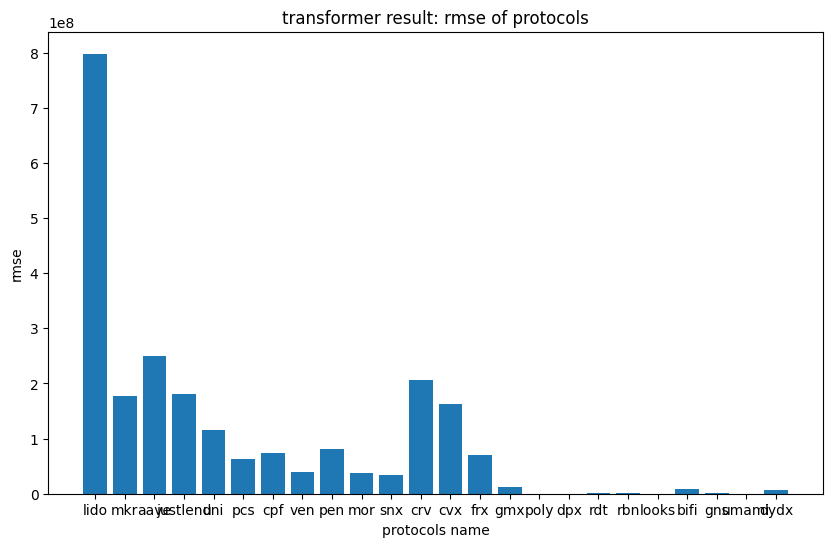

In [4]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import requests
import io
import datetime as dt
import matplotlib.pyplot as plt

try:
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

class TransformerModel(nn.Module):
   def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
          super(TransformerModel, self).__init__()

          self.encoder = nn.Linear(input_dim, d_model)
          self.pos_encoder = PositionalEncoding(d_model, dropout)
          encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
          self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
          self.decoder = nn.Linear(d_model, 1)

   def forward(self, x):
          x = self.encoder(x)
          x = self.pos_encoder(x)
          x = self.transformer_encoder(x)
          x = self.decoder(x[:, -1, :])
          return x


class PositionalEncoding(nn.Module):
      def __init__(self, d_model, dropout=0.1, max_len=5000):
          super(PositionalEncoding, self).__init__()
          self.dropout = nn.Dropout(p=dropout)

          pe = torch.zeros(max_len, d_model)
          position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
          div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
          pe[:, 0::2] = torch.sin(position * div_term)
          pe[:, 1::2] = torch.cos(position * div_term)
          pe = pe.unsqueeze(0).transpose(0, 1)
          self.register_buffer('pe', pe)

      def forward(self, x):
          x = x + self.pe[:x.size(0), :]
          return self.dropout(x)
      
  # train test split


def to_sequences(seq_size, obs):
      x = []
      y = []
      for i in range(len(obs) - seq_size):
          window = obs[i:(i + seq_size)]
          after_window = obs[i + seq_size]
          x.append(window)
          y.append(after_window)
      return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

global final_result_df
final_result_df = pd.DataFrame(columns=['Protocol', 'rmse', 'Predictions'])

def transformer(inputdata,protocol,var='TVL'):

    df = inputdata
    
    df_train = df[:len(df)*4//5]
    df_test = df[len(df)*4//5:]

    protocol_train = inputdata[var].to_numpy().reshape(-1, 1)
    protocol_test = inputdata[var].to_numpy().reshape(-1, 1)
    scaler = StandardScaler()


    #protocol_train = scaler.fit_transform(protocol_train).flatten().tolist()
    #protocol_test = scaler.transform(protocol_test).flatten().tolist()
    protocol_train = scaler.fit_transform(protocol_train).ravel().tolist()
    protocol_test = scaler.transform(protocol_test).ravel().tolist()

  # Sequence Data Preparation
    SEQUENCE_SIZE = 10
    x_train, y_train = to_sequences(SEQUENCE_SIZE, protocol_train)
    x_test, y_test = to_sequences(SEQUENCE_SIZE, protocol_test)
    
  # Setup data loaders for batch
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    model = TransformerModel().to(device)

  # Train the model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

    epochs = 1000
    early_stop_count = 0
    min_val_loss = float('inf')

    for epoch in range(epochs):
      model.train()
      for batch in train_loader:
          x_batch, y_batch = batch
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)

          optimizer.zero_grad()
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          loss.backward()
          optimizer.step()
      model.eval()
      val_losses = []
      with torch.no_grad():
          for batch in test_loader:
              x_batch, y_batch = batch
              x_batch, y_batch = x_batch.to(device), y_batch.to(device)
              outputs = model(x_batch)
              loss = criterion(outputs, y_batch)
              val_losses.append(loss.item())

      val_loss = np.mean(val_losses)
      scheduler.step(val_loss)

      if val_loss < min_val_loss:
          min_val_loss = val_loss
          early_stop_count = 0
      else:
          early_stop_count += 1

      if early_stop_count >= 2:
        #   print("Early stopping!")
          break
    #   print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)


            #predictions.extend(outputs.squeeze().tolist())
            #predictions.extend(outputs.squeeze().cpu().numpy().tolist())
            predictions.extend(outputs.cpu().numpy().flatten().tolist())


    rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
    print(f"{protocol} : Score (RMSE): {rmse:.2f}")
    # print(predictions)
    final_result_df.loc[len(final_result_df)] = [protocol,rmse,predictions]
    return final_result_df



device = (
    "GPU" # Mac mps
    if torch.backends.mps.is_built()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
# print(f"Using device: {device}")

#import data from github link
url = "https://raw.githubusercontent.com/grt1999/Main/main/final_combined_data.csv"
s=requests.get(url).content
all_data=pd.read_csv(io.StringIO(s.decode('utf-8'))).iloc[:]
all_data.rename(columns={"protocol name": "protocol"}, inplace=True)

all_data['TVL'] = all_data['TVL'].astype(float)
all_data['date'] = pd.to_datetime(all_data['date'])
all_data['year'] = all_data['date'].dt.year

# print("data updated (time: {})".format(dt.datetime.now()+dt.timedelta(minutes = 0)))
all_data.head()

#RUN THE TRANSFORMER FUNCTION on each protocol respectively
# print("start transformer engine: {}".format(dt.datetime.now()))
for protocols in all_data['protocol'].unique():
    transformer(all_data[all_data['protocol'] == protocols],protocols)
    final_result = final_result_df[['Protocol','rmse']]


def format_number(number):
    num = float(number)
    scaled_num = num / 1e8
    return f"{scaled_num:.0f}"

final_result.loc[:, 'rmse'] = final_result['rmse'].apply(format_number).astype(float)

def get_rank_select(num):
    try:
        num = int(num)  # Convert num to an integer
    except ValueError:
        return "Invalid value"  # Return this if num cannot be converted to an integer

    if 0 <= num <= 2:
        return 'Low'
    elif 3 <= num <= 5:
        return 'Medium'
    elif 6 <= num <= 8:
        return 'Medium High'
    elif 9 <= num <= 10:
        return 'High'
    else:
        return "Invalid value"

# Apply the function to the DataFrame column
final_result['Risk Level'] = final_result['rmse'].apply(get_rank_select)

rename_mapping = {
    'dydx': 'DYDX',
    'umami': 'Umami',
    'gns': 'Gains Network',
    'bifi': 'Beefy',
    'looks': 'LooksRare',
    'rbn': 'Ribbon Finance',
    'rdt': 'Redacted Finance',
    'dpx': 'Dopex',
    'gmx': 'GMX',
    'crv': 'Curve',
    'snx': 'Synthetix'
}

# Use the `replace` method to rename the values
final_result['Protocol'] = final_result['Protocol'].replace(rename_mapping)

# renmae rmse column
final_result = final_result.rename(columns={'rmse': 'RMSE'})

plt.figure(figsize=(10, 6))
plt.bar(final_result_df['Protocol'],final_result_df['rmse'])
plt.xlabel("protocols name")
plt.ylabel("rmse")
plt.title("transformer result: rmse of protocols")

#acess to the data
url = 'https://raw.githubusercontent.com/grt1999/Main/main/final_combined_data.csv'
s=requests.get(url).content
all_data=pd.read_csv(io.StringIO(s.decode('utf-8'))).iloc[:,:]
all_data.replace('nan', np.nan, inplace=True)
all_data.rename(columns={"protocol name": "protocol"}, inplace=True)

url = "https://raw.githubusercontent.com/grt1999/Main/main/final_combined_data.csv"
s=requests.get(url).content
all_data=pd.read_csv(io.StringIO(s.decode('utf-8'))).iloc[:,:]
all_data.replace('nan', np.nan, inplace=True)
all_data.rename(columns={"protocol name": "protocol"}, inplace=True)


dydx_data = all_data[all_data['protocol'] == 'dydx']

#return the newest from the data
def get_newest(data):
    if data.iloc[-1].isnull().sum() == 0:
        return data.iloc[-1]
    else:
        return data.iloc[-2]
#get_newest(dydx_data)
new_df = pd.DataFrame(columns = all_data.columns)
for protocols in all_data['protocol'].unique():
    new_df.loc[len(new_df)] = list(get_newest(all_data[all_data['protocol'] == protocols]))

#del new_df['date]
#plt.bar(new_df['protocol'], new_df['price'])
rename_mapping = {
    'dydx': 'DYDX',
    'umami': 'Umami',
    'gns': 'Gains Network',
    'bifi': 'Beefy',
    'looks': 'LooksRare',
    'rbn': 'Ribbon Finance',
    'rdt': 'Redacted Finance',
    'dpx': 'Dopex',
    'gmx': 'GMX',
    'crv': 'Curve',
    'snx': 'Synthetix'
}

# new_df['protocol'] = new_df['protocol'].replace(rename_mapping)
#combine the latest metrics with the final result of transformer
# df_for_pre = pd.merge(new_df, final_result, left_on='protocol',right_on='Protocol')
# print(df_for_pre)
# df_for_pre.to_csv('df_for_pre.csv')

# new_df.to_csv('new_df_for_pre.csv') 

## Outcome

In [7]:
final_result_df

,Protocol,rmse,Predictions
0,lido,7.978909e+08,"[-1.7561856508255005, -1.7562203407287598, -1...."
1,mkr,1.764641e+08,"[0.12025046348571777, 0.14920338988304138, 0.3..."
2,aave,2.496103e+08,"[-1.0128875970840454, -1.0110982656478882, -0...."
3,justlend,1.814552e+08,"[-1.2592459917068481, -1.269804835319519, -1.2..."
4,uni,1.153666e+08,"[-1.435043454170227, -1.4514883756637573, -1.2..."
5,pcs,6.303704e+07,"[1.594752311706543, 1.618173599243164, 1.73167..."
6,cpf,7.361947e+07,"[-0.9742820858955383, -1.0444676876068115, -1...."
7,ven,3.969504e+07,"[-0.5551384091377258, -0.5279926657676697, -0...."
8,pen,8.043794e+07,"[-0.42520207166671753, -0.4467867612838745, -0..."
9,mor,3.796332e+07,"[-1.283207893371582, -1.3017061948776245, -1.2..."


In [9]:
final_result.drop(columns='Risk Level')

,Protocol,RMSE
0,lido,8.0
1,mkr,2.0
2,aave,2.0
3,justlend,2.0
4,uni,1.0
5,pcs,1.0
6,cpf,1.0
7,ven,0.0
8,pen,1.0
9,mor,0.0
